# Comparison of All Models - Backtesting, Vizualization

This notebook compares all internal models, as well as the standard formula approach. The comparison will be done with the implemented backtesting in mind. 

Additional plots, and vizualizations might be presented.

# Lage innholdsfortegnelse

In [26]:
from internal_models.historical_simulation.historical_simulation import HistoricalSimulation
from internal_models.montecarlo.mc_copula import MonteCarloCopula
from internal_models.montecarlo.mc_vanillagbm import MonteCarloVanillaGBM
from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from backtesting.var_tests.christoffersens_test import christoffersen_independence_test
from backtesting.var_tests.kupiec_test import kupiec_pof_test
from internal_models.GANs.tuned_GANS import solveig_GAN, astrid_GAN, willow_GAN
from utilities.bof_var_plot import plot_bof_var
from utilities.model_saving import save_results, is_results_empty, load_results
from utilities.bof_var_plot import plot_bof_var
from utilities.gan_plotting import extensive_plotting

import pandas as pd
from tqdm import tqdm
import numpy as np
from dotenv.main import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
load_dotenv(override=True)
import os

### Fixing the data. Splitting the data in a testing period.

Split date is set inside environment file.

In [27]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

## Creating quarterly returns for test period

We might experiment with updating the SCR at quarterly rate.

In [ ]:
from utilities.split_into_quarters import split_into_quarters

quarterly_returns = split_into_quarters(test_returns_df)

# A little sanity check to see if the shapes are correct.
for asset in quarterly_returns:
    print(asset, ":", quarterly_returns[asset].shape)

REEL : (4, 63)
PE : (4, 63)
MSCIWORLD : (4, 63)
IG : (4, 63)
GOV : (4, 63)
HY : (4, 63)
EONIA : (4, 63)


### Deciding on weights for portfolio

**ATTENTION:** Assuming an equally weighted portfolio for now

In [3]:
num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

### Other Parameters

In [4]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Calculating SCR with common Internal Models

I.e the following models:

- Historical Simulation
- Monte Carlo simulations with Copulas (Student t's)
- Monte Carlo, vanilla GBM. No correlations between assets assumed
- Monte Carlo, GBM with jumps and correlations between assets

In [5]:
hs = HistoricalSimulation(returns_df, weights)
mc_copula = MonteCarloCopula(returns_df, weights)
mc_vanilla_GBM = MonteCarloVanillaGBM(returns_df, weights)
mc_jump_gbm = MonteCarloJumpGBM(returns_df, weights)

## Decide on using saved model results, or recalculating

In [6]:
use_saved = True

In [7]:
if not use_saved or is_results_empty():
    dist_hs, scr_hs = hs.calculate_distribution_and_scr()
    save_results(model_name="Historical Simulation", distribution=dist_hs, scr=scr_hs, weights=weights, overwrite=True)

    dist_mc_copula, scr_mc_copula = mc_copula.calculate_distribution_and_scr()
    save_results(model_name="MC Copula", distribution=dist_mc_copula, scr=scr_mc_copula, weights=weights, overwrite=False)

    dist_mc_vanilla_gbm, scr_mc_vanilla_gbm = mc_vanilla_GBM.calculate_distribution_and_scr()
    save_results(model_name="MC Vanilla GBM", distribution=dist_mc_vanilla_gbm, scr=scr_mc_vanilla_gbm, weights=weights, overwrite=False)

    dist_mc_jump_gbm, scr_mc_jump_gbm = mc_jump_gbm.calculate_distribution_and_scr()
    save_results(model_name="GBM with Poisson Jumps and Intra-Asset Correlations", distribution=dist_mc_jump_gbm, scr=scr_mc_jump_gbm, weights=weights, overwrite=False)

## Plotting Distributions and displaying the SCR

Where the SCR is the Value-at-Risk at 99.5%. 

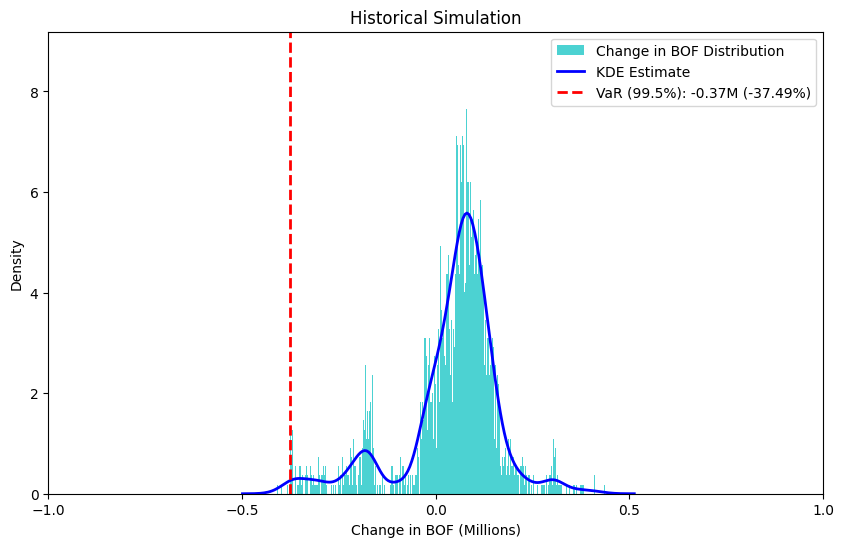

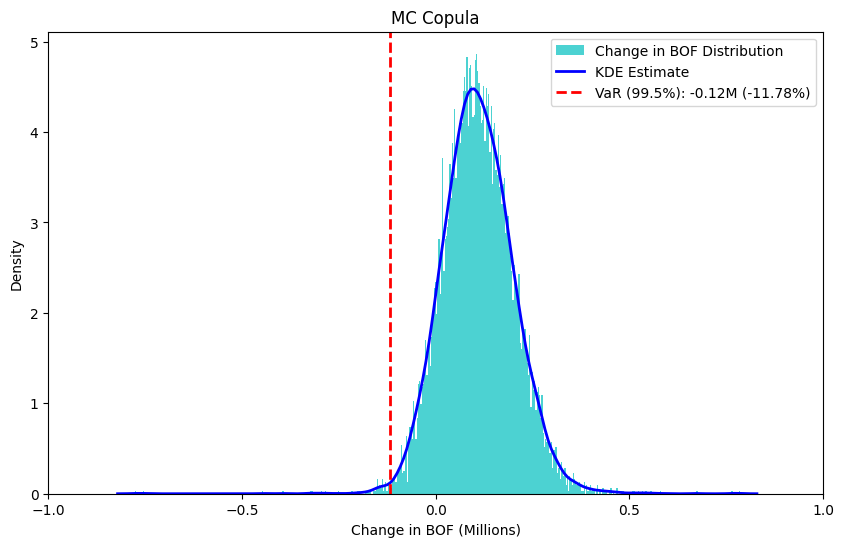

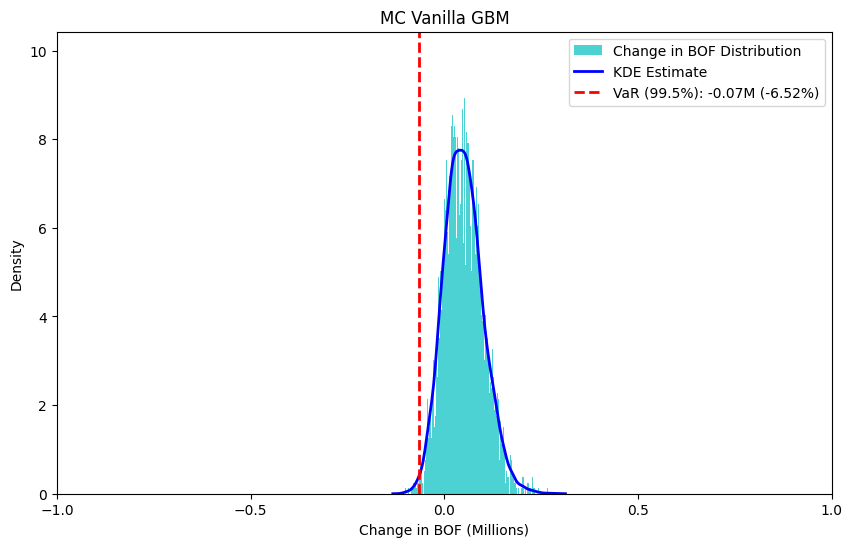

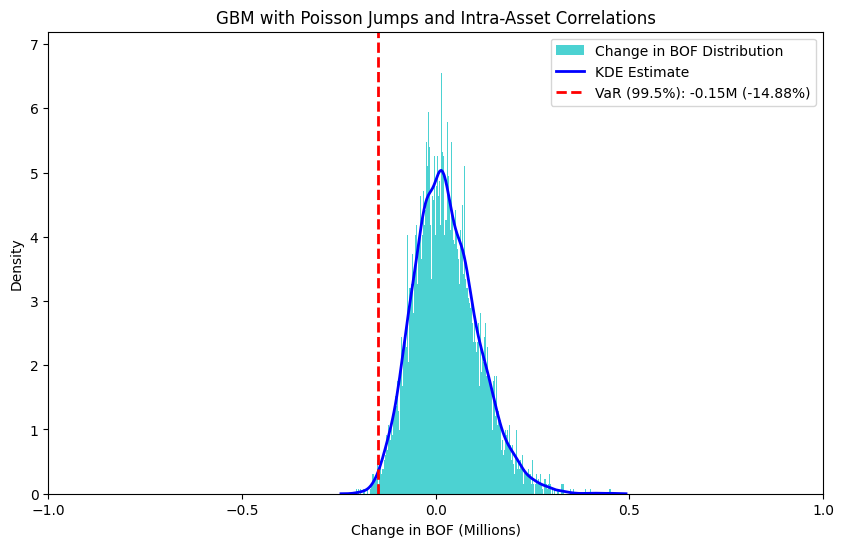

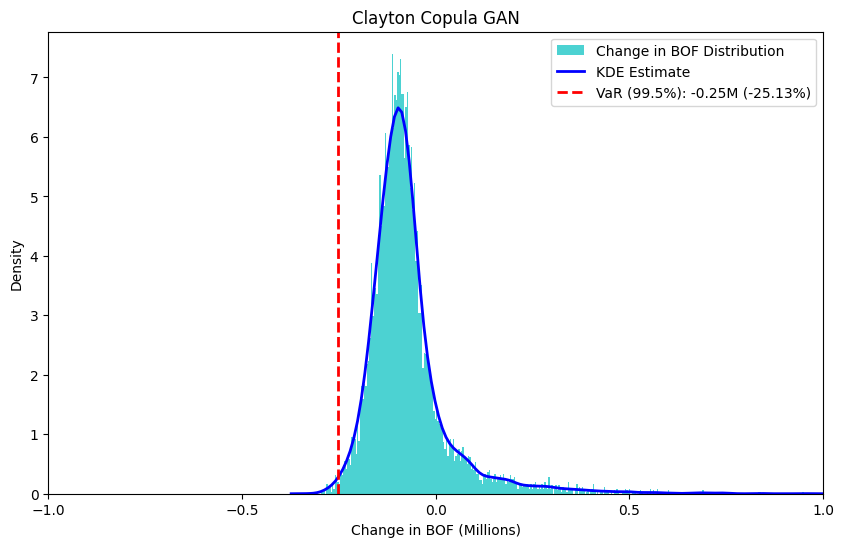

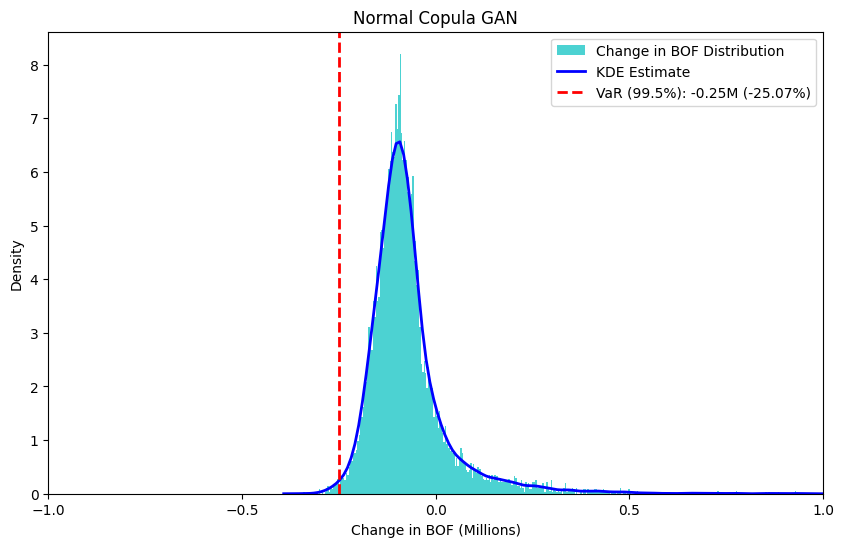

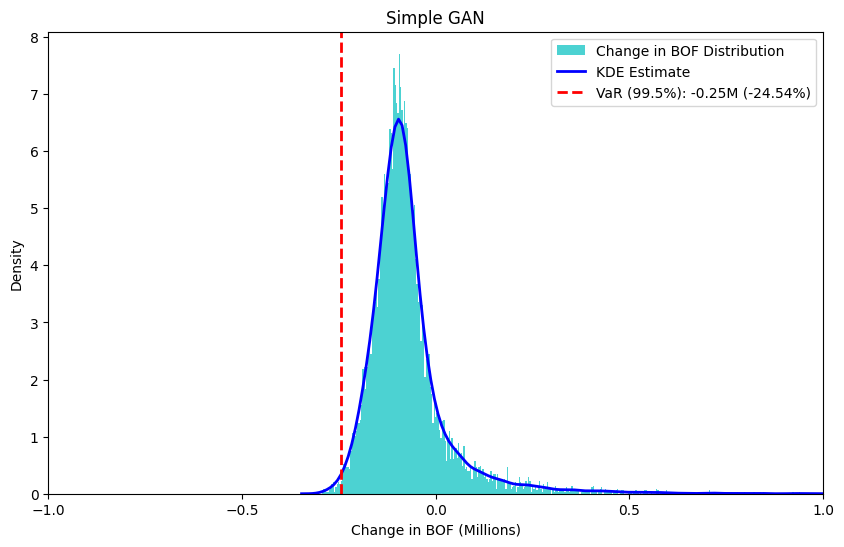

In [8]:
results = load_results()
for model_name, result in results.items():
    plot_bof_var(result['distribution'], result['scr'], model_name, bof_0),

## Internal Models using Neural Networks - GANs

Relevant plots:
- Generated distributions for each asset class, with statistics
- PCA plot
- Tests relevant to GANs
    - Mode Collaps
    - Variance
    - Wasserstein distance plot

A GAN is trained on each asset class, creating generated distribution for 1 year ahead. These distributions are then aggregated using Copulas.

In [9]:
from internal_models.GANs.tuned_GANS.astrid_GAN import AstridGAN
from internal_models.GANs.tuned_GANS.willow_GAN import WillowGAN

## Training the GANs if spesified, otherwise the already generated returns will be used

In [10]:
train_gans = False

In [11]:
if train_gans:
    for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
        print(f"Training GAN for {asset_name}...")
        asset_returns = returns_df[asset_name]

        if asset_name == 'EONIA':
            gan = WillowGAN(asset_returns, asset_name)
        else:
            gan = AstridGAN(asset_returns, asset_name)
        
        gan.train()
        
        print(f"Finished training GAN for {asset_name}.\n")

        gan.generate_scenarios(num_scenarios=num_simulations)

        print(f"Finished generating scenarios GAN {asset_name}.\n")

Presenting GAN results

⚠️ Warning: NaNs or Infs detected in generated returns for EONIA. Fixing...


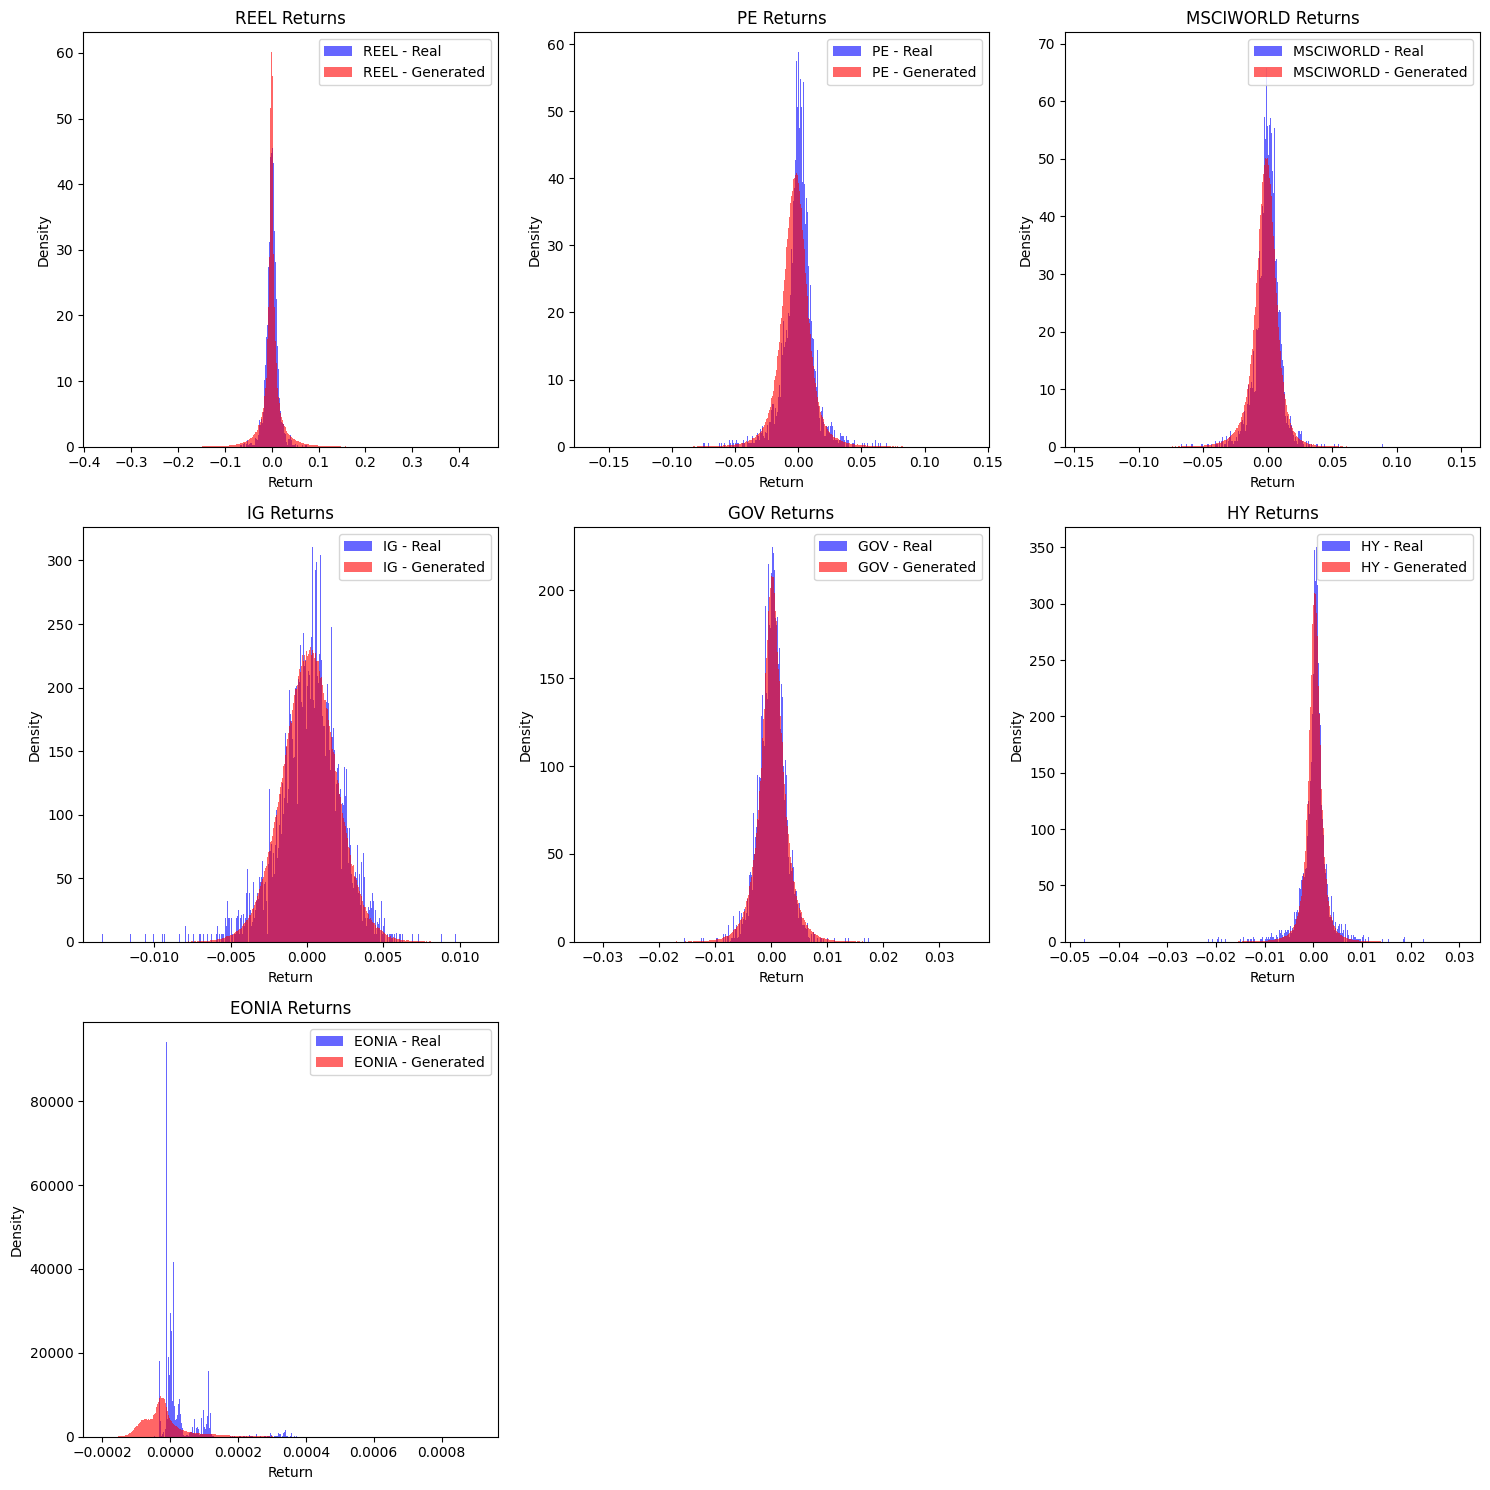


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.000007 0.024641  0.318428 16.334991  -0.098734
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.002414 0.013324  0.001886  5.554672  -0.048584
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.001737 0.010923 -0.430412  5.757589  -0.041921
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated  0.000160 0.001826 -0.021427  0.421329  -0.004844
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000228 0.002693  0.064499  4.058693  -0.008528
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated  0.000253 0.002147 -0.354940 11.875720  -0.008283
         EONIA - Real  0.000032 0.

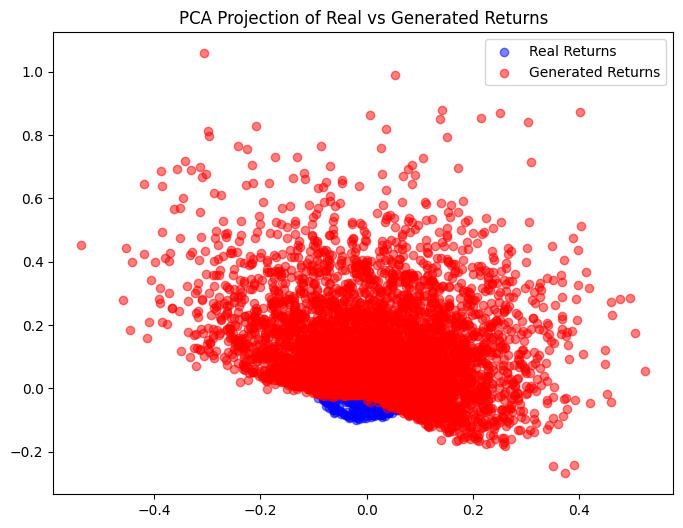

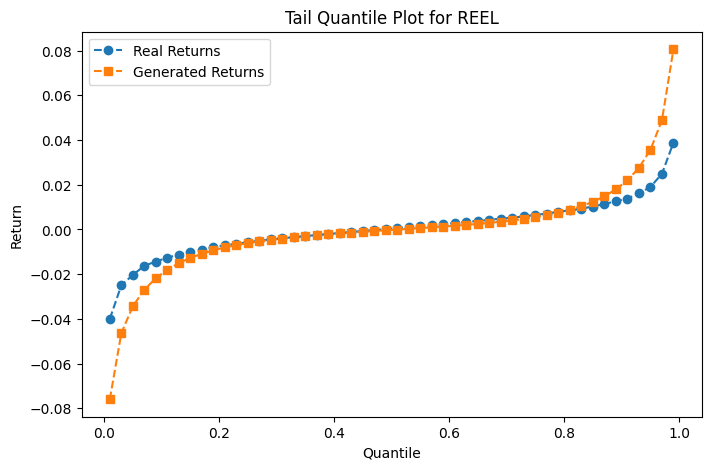


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════


📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 13.621436
Mean Distance: 0.005487
Median Distance: 0.000247
Standard Deviation: 0.101738


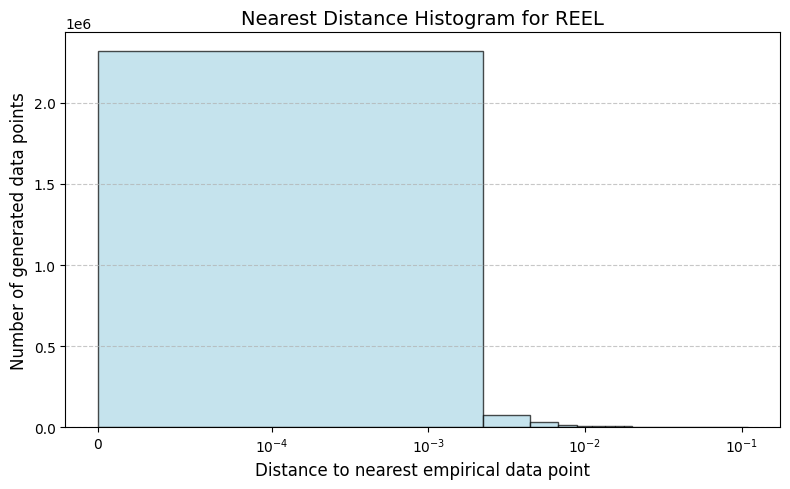


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

📊 Wasserstein Distance for REEL: 0.005143


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Variance of Real Data: 0.000162
Variance of Generated Data: 0.000131
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.231009
✅ Generated samples are reasonably diverse



══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════


📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 6.117751
Mean Distance: 0.002346
Median Distance: 0.000317
Standard Deviation: 0.037025


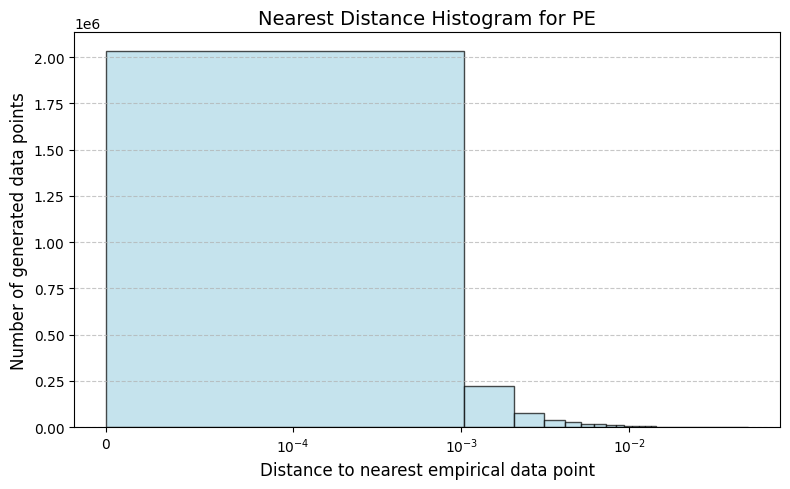


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

📊 Wasserstein Distance for PE: 0.002706


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Variance of Real Data: 0.000098
Variance of Generated Data: 0.000087
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.192031
✅ Generated samples are reasonably diverse


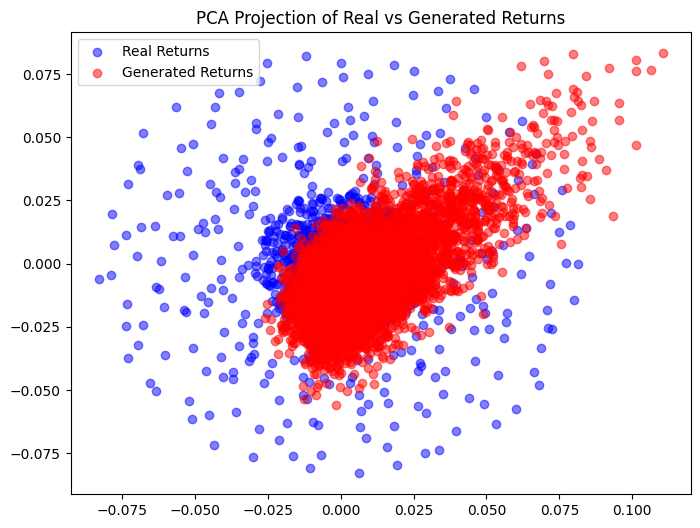

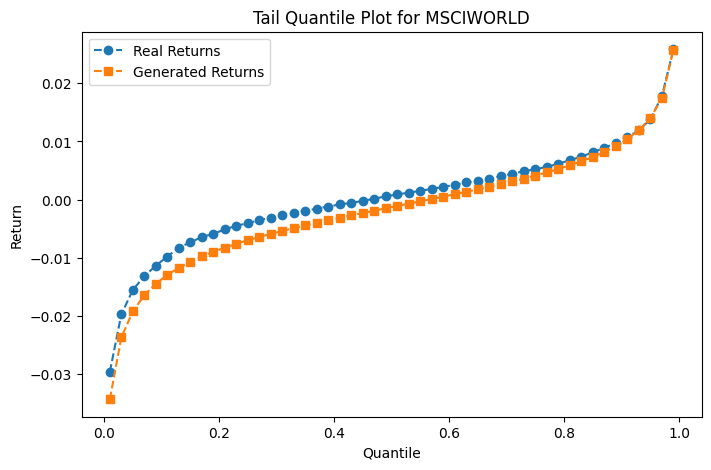


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════


📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 6.270639
Mean Distance: 0.002105
Median Distance: 0.000316
Standard Deviation: 0.029520


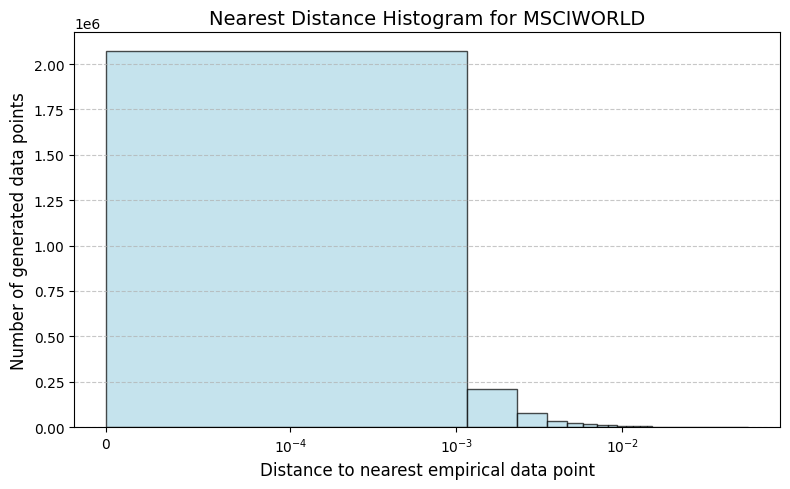


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

📊 Wasserstein Distance for MSCIWORLD: 0.002038


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Variance of Real Data: 0.000004
Variance of Generated Data: 0.000003
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.036375
✅ Generated samples are reasonably diverse


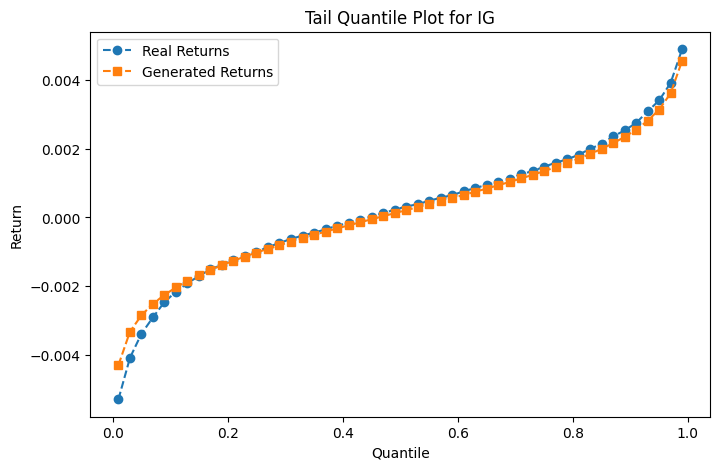


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════


📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 2.397597
Mean Distance: 0.001231
Median Distance: 0.000378
Standard Deviation: 0.007396


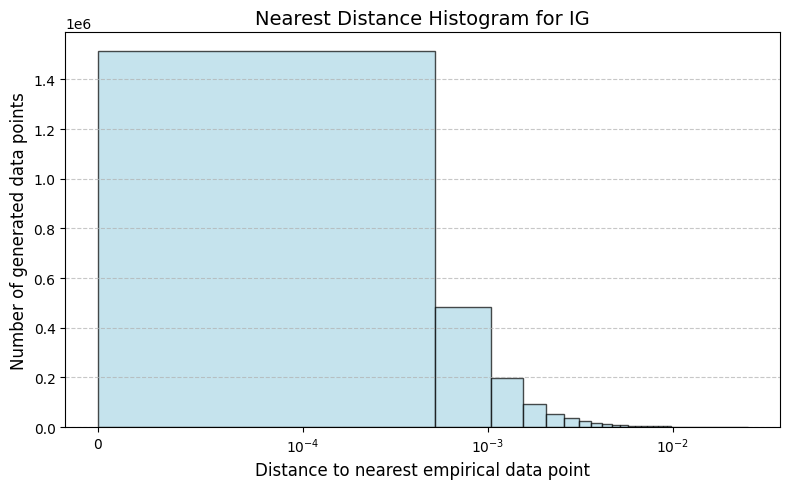


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

📊 Wasserstein Distance for IG: 0.000171


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Variance of Real Data: 0.000006
Variance of Generated Data: 0.000005
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.046880
✅ Generated samples are reasonably diverse


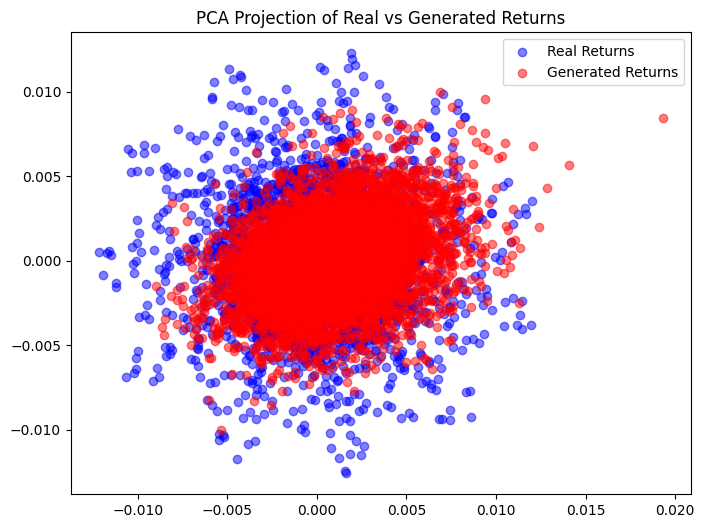


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════


📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 5.995261
Mean Distance: 0.001991
Median Distance: 0.000331
Standard Deviation: 0.025964


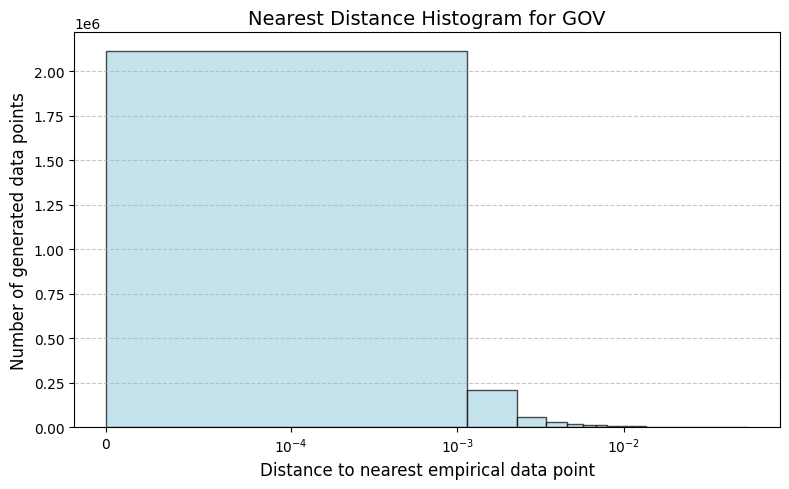


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

📊 Wasserstein Distance for GOV: 0.000148


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Variance of Real Data: 0.000009
Variance of Generated Data: 0.000004
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.038216
✅ Generated samples are reasonably diverse


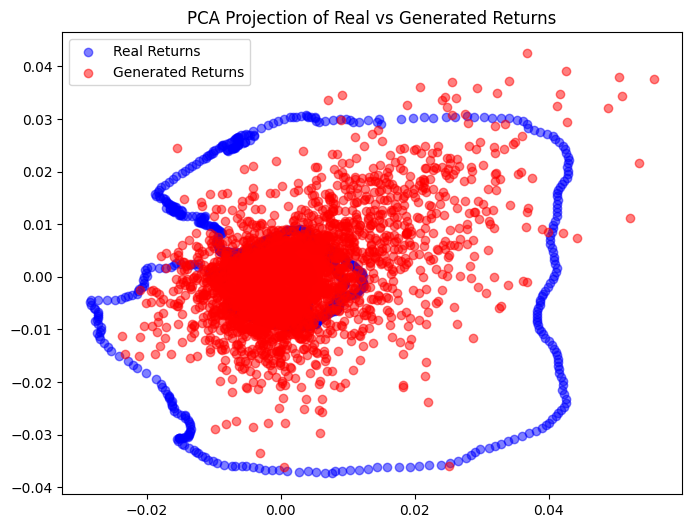

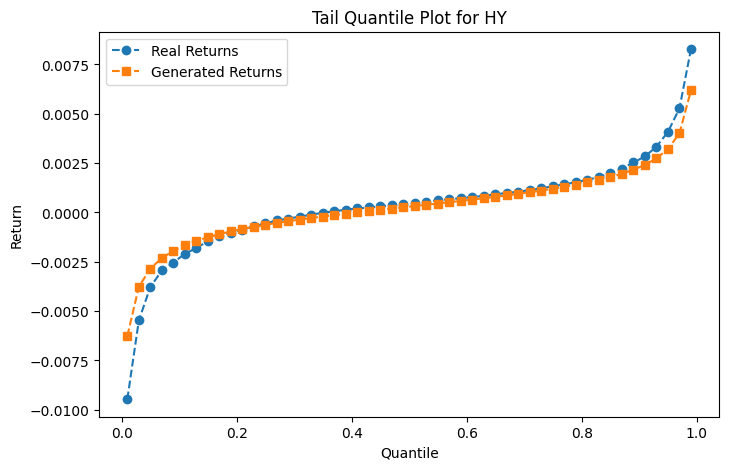


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════


📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 6.145090
Mean Distance: 0.002914
Median Distance: 0.000280
Standard Deviation: 0.040134


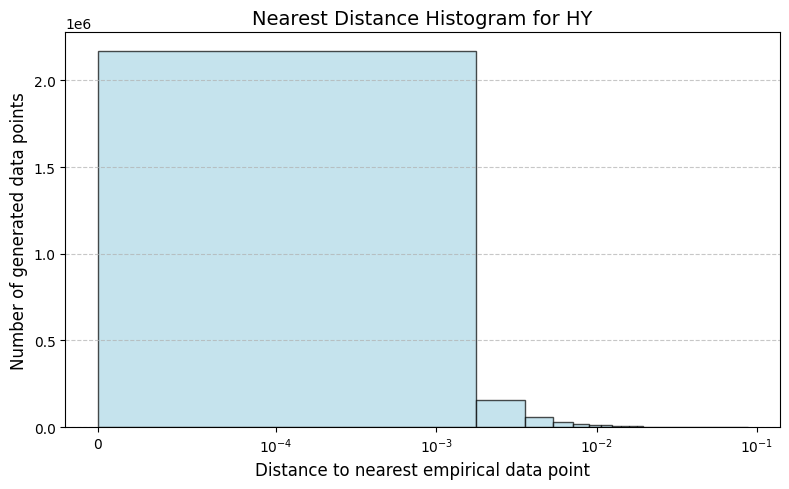


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

📊 Wasserstein Distance for HY: 0.000400


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000655
✅ Generated samples are reasonably diverse



═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

📊 Wasserstein Distance for EONIA: nan



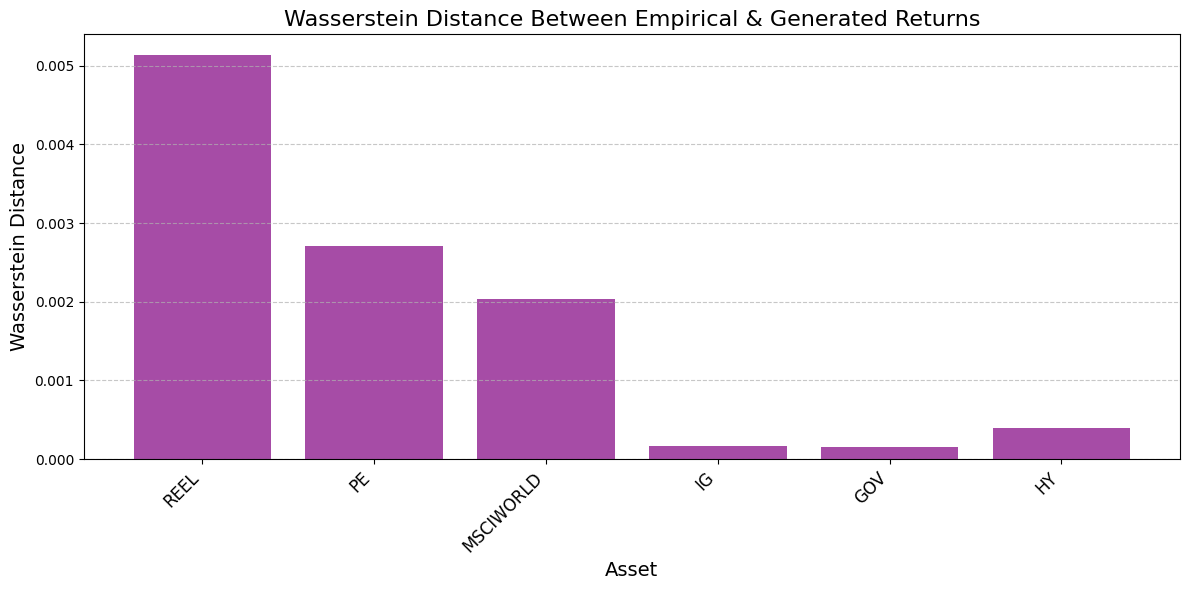

In [12]:
extensive_plotting(scaled=False, returns_df=returns_df)

## Add a Preliminary backtesting for each individual GAN

This is meant as a preliminary backtesting for each asset created by individual GANs. Backtesting is done on returns, not BOF (yet).

1. Backtesting plots will be presented
2. Statistical tests will be made
3. Accuracy/adaquecy tests will be made

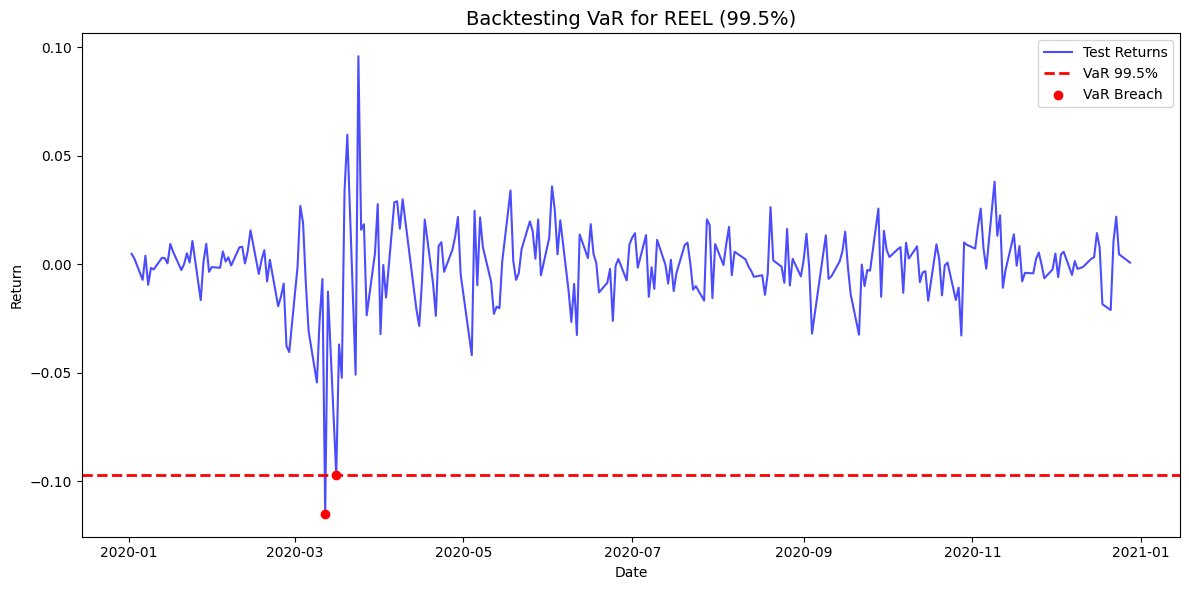


📊 VaR Backtesting Summary for REEL:
VaR 99.5% threshold: -0.097049
Failures (breaches below VaR): 2 times

📊 VaR Backtesting Results for REEL

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 0.3703
📊 p-value: 0.542826
🚦 Test Conclusion: ✅ Passed (p > 0.1) - No significant failure pattern detected 🎉

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 23.2972
📊 p-value: 0.000001
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 23.6675
📊 p-value: 0.000007
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.008071
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.008071
🚦 A higher value is worse.

Distribution Tests for REEL
Overall Moments Comparison:
Generated -> Mean: 0.0000, Std: 0.0244, Skewness: 0.3167
Empirical -> Mean: 0.0002, Std: 0.

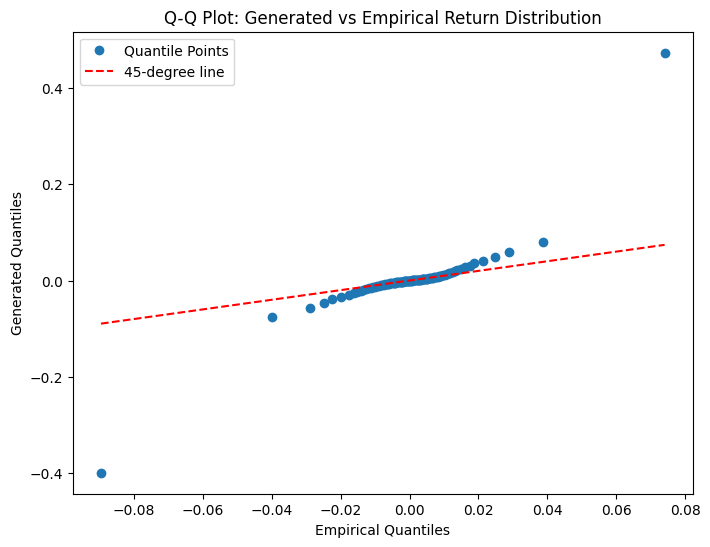


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 15.209116
Overall Mean Empirical Excess Kurtosis: 4.969059015521381
Difference (Generated - Empirical): 10.240056966534283
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.


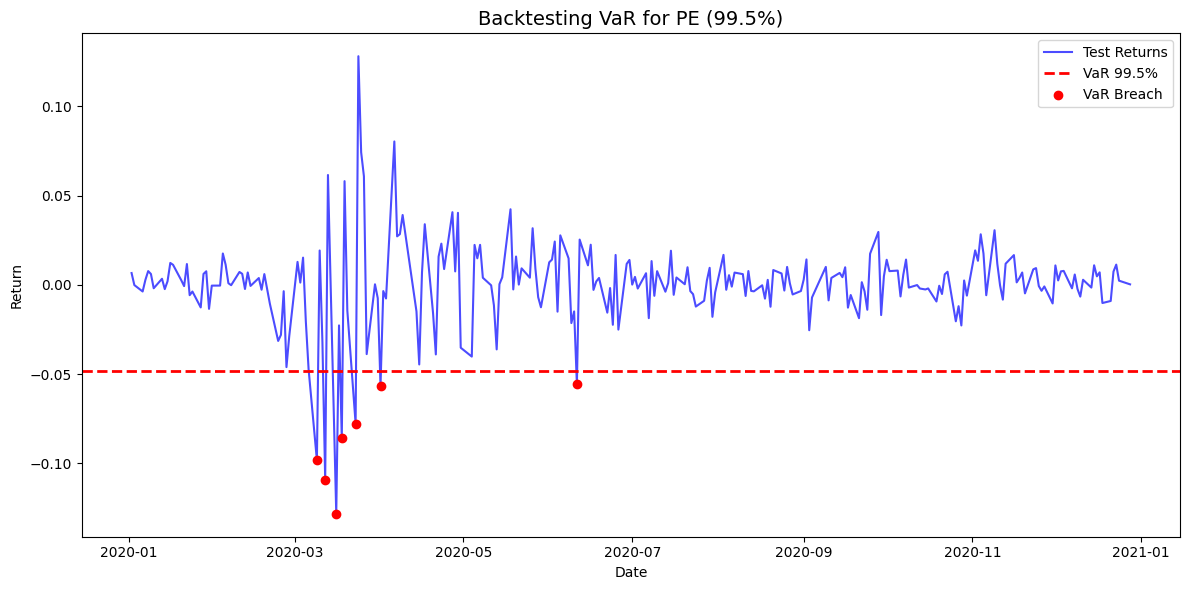


📊 VaR Backtesting Summary for PE:
VaR 99.5% threshold: -0.048315
Failures (breaches below VaR): 7 times

📊 VaR Backtesting Results for PE

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 12.6596
📊 p-value: 0.000374
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 63.8599
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 76.5194
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.053276
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.053276
🚦 A higher value is worse.

Distribution Tests for PE
Overall Moments Comparison:
Generated -> Mean: -0.0024, Std: 0.0133, Skewness: 0.0039
Empirical -> Mean: 0.0002, Std: 0.0127, Skewnes

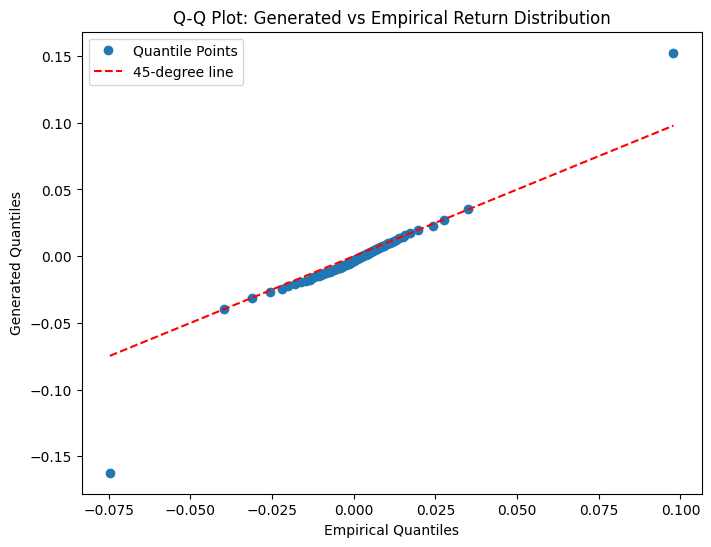


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 5.5322895
Overall Mean Empirical Excess Kurtosis: 6.380429483234719
Difference (Generated - Empirical): -0.8481399782298364
Interpretation: The generated distribution's tail heaviness is close to the empirical benchmark.


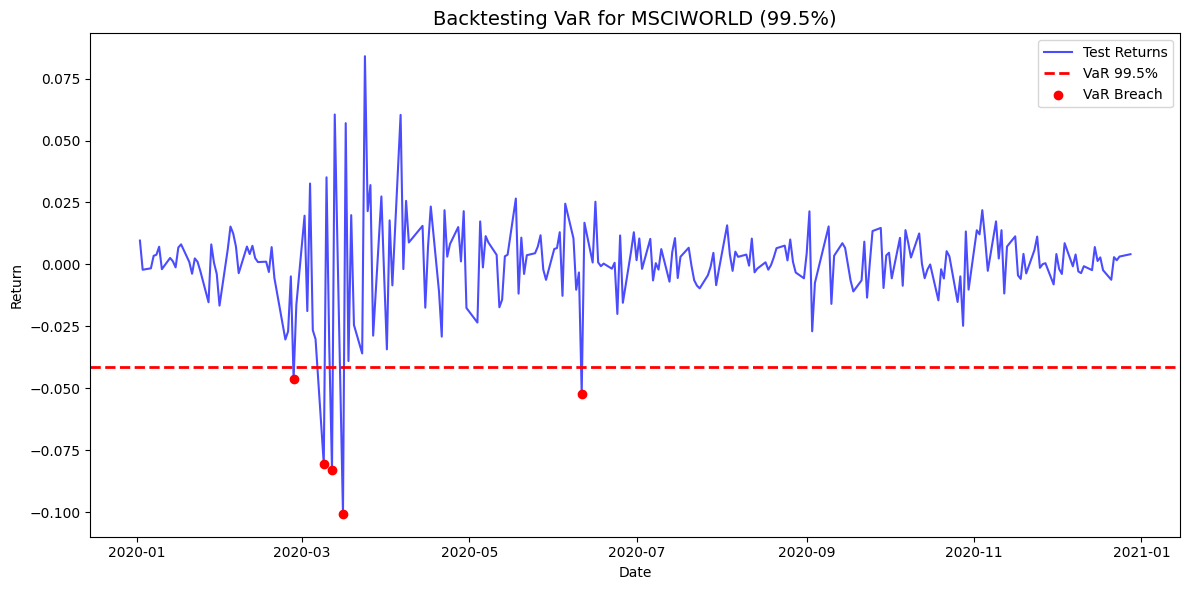


📊 VaR Backtesting Summary for MSCIWORLD:
VaR 99.5% threshold: -0.041528
Failures (breaches below VaR): 5 times

📊 VaR Backtesting Results for MSCIWORLD

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 6.3593
📊 p-value: 0.011677
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 49.0196
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 55.3789
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.035652
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.035652
🚦 A higher value is worse.

Distribution Tests for MSCIWORLD
Overall Moments Comparison:
Generated -> Mean: -0.0017, Std: 0.0109, Skewness: -0.4101
Empirical -> Mean: 0.0003,

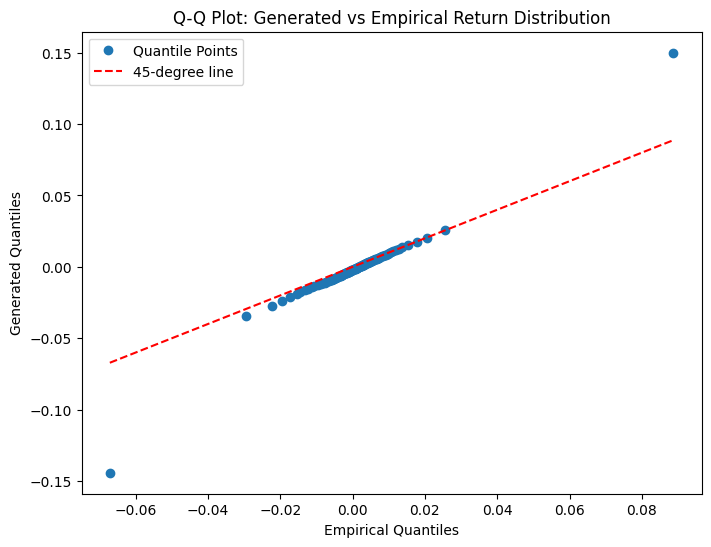


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 5.647873
Overall Mean Empirical Excess Kurtosis: 7.35992278471412
Difference (Generated - Empirical): -1.712049859909433
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


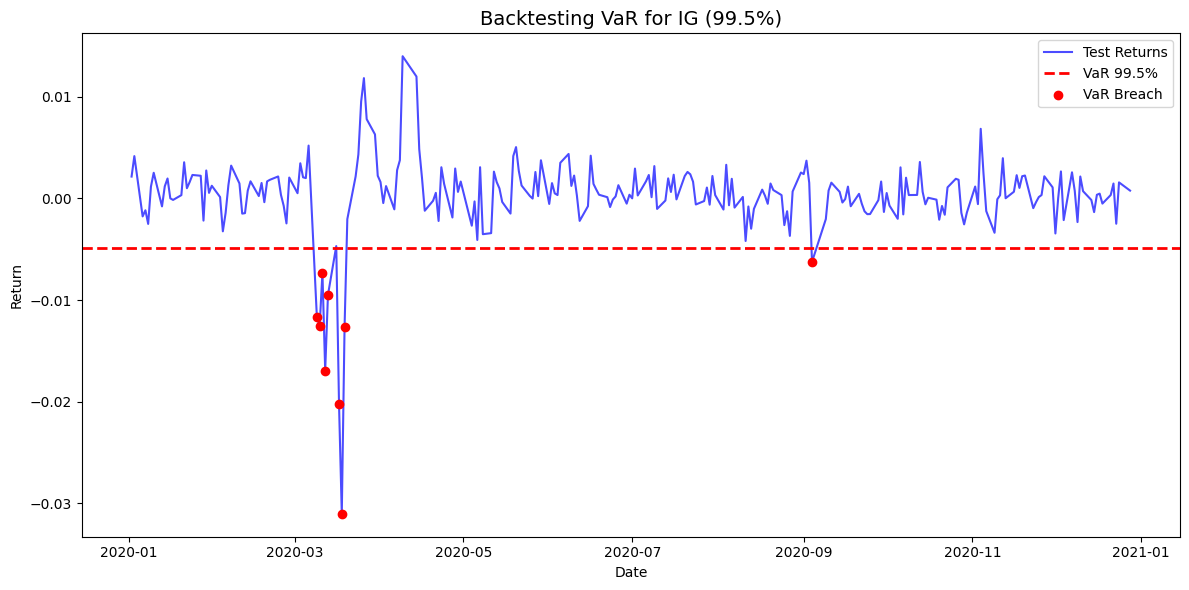


📊 VaR Backtesting Summary for IG:
VaR 99.5% threshold: -0.004853
Failures (breaches below VaR): 9 times

📊 VaR Backtesting Results for IG

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 20.1515
📊 p-value: 0.000007
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 77.5083
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 97.6597
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.249338
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.249338
🚦 A higher value is worse.

Distribution Tests for IG
Overall Moments Comparison:
Generated -> Mean: 0.0002, Std: 0.0018, Skewness: -0.0211
Empirical -> Mean: 0.0002, Std: 0.0021, Skewnes

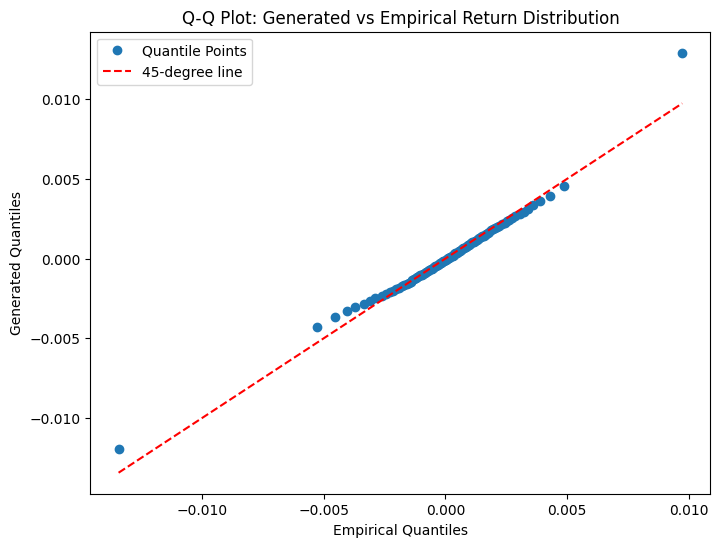


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 0.45121312
Overall Mean Empirical Excess Kurtosis: 2.2266180367406516
Difference (Generated - Empirical): -1.775404915326467
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.



📊 VaR Backtesting Summary for GOV:
VaR 99.5% threshold: -0.008551
Failures (breaches below VaR): 4 times

📊 VaR Backtesting Results for GOV

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 3.7915
📊 p-value: 0.051513
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 41.0170
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 44.8085
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.022260
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.022260
🚦 A higher value is worse.

Distribution Tests for GOV
Overall Moments Comparison:
Generated -> Mean: 0.0002, Std: 0.0027, Skewness: 0.0592
Empirical -> Mean: 0.0002, Std: 0.0024, Skewne

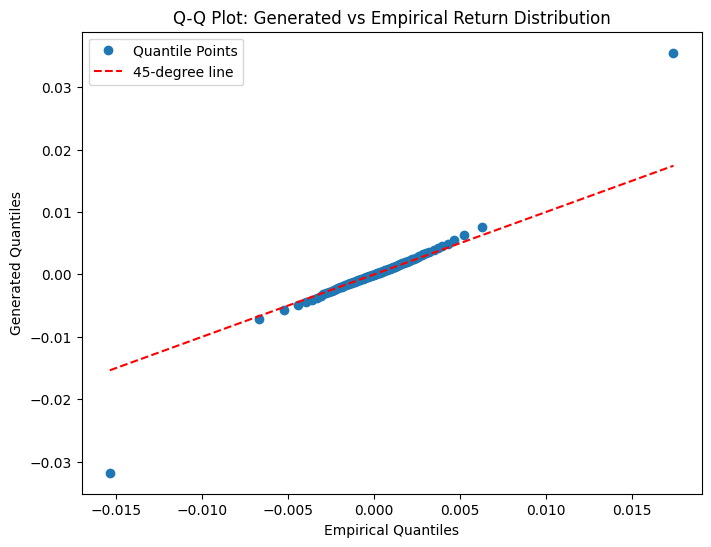


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 3.8634157
Overall Mean Empirical Excess Kurtosis: 4.018642134505793
Difference (Generated - Empirical): -0.15522641642717971
Interpretation: The generated distribution's tail heaviness is close to the empirical benchmark.


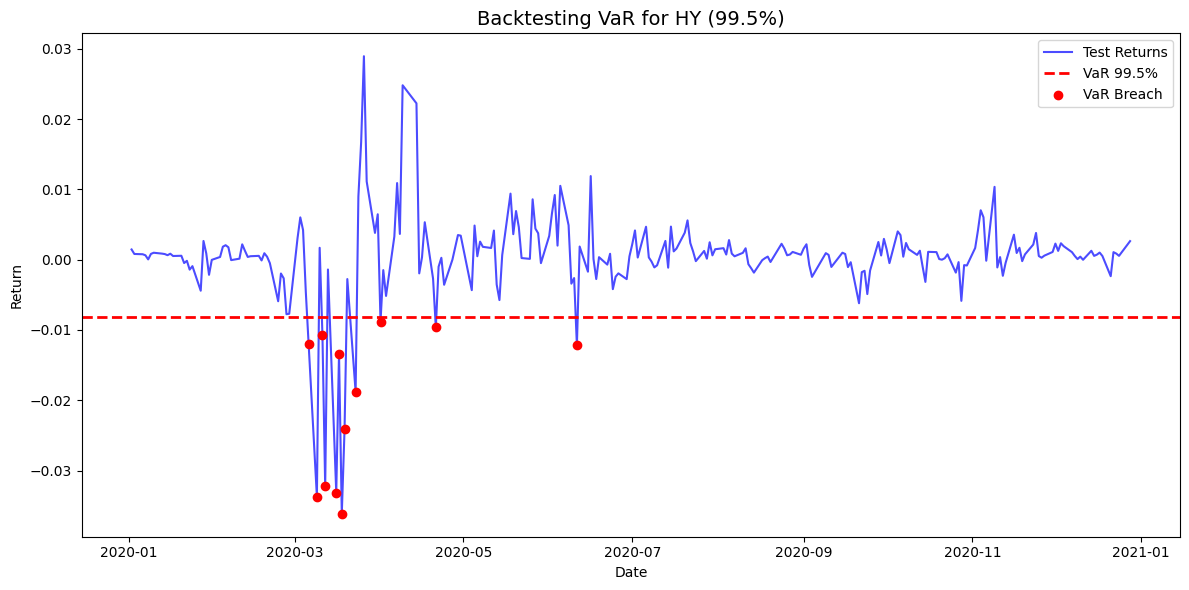


📊 VaR Backtesting Summary for HY:
VaR 99.5% threshold: -0.008142
Failures (breaches below VaR): 12 times

📊 VaR Backtesting Results for HY

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 33.0778
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 96.2919
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 129.3697
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.232200
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.232200
🚦 A higher value is worse.

Distribution Tests for HY
Overall Moments Comparison:
Generated -> Mean: 0.0003, Std: 0.0021, Skewness: -0.3550
Empirical -> Mean: 0.0003, Std: 0.0030, Skewn

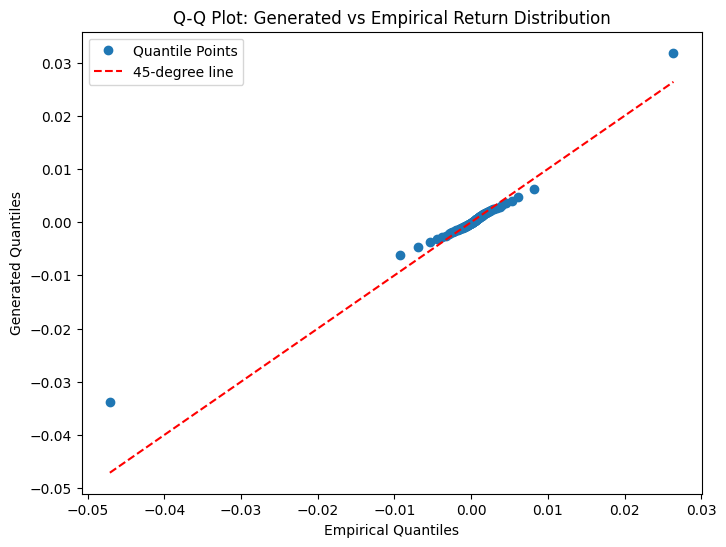


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 11.831663
Overall Mean Empirical Excess Kurtosis: 31.425102249989934
Difference (Generated - Empirical): -19.593439118276066
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


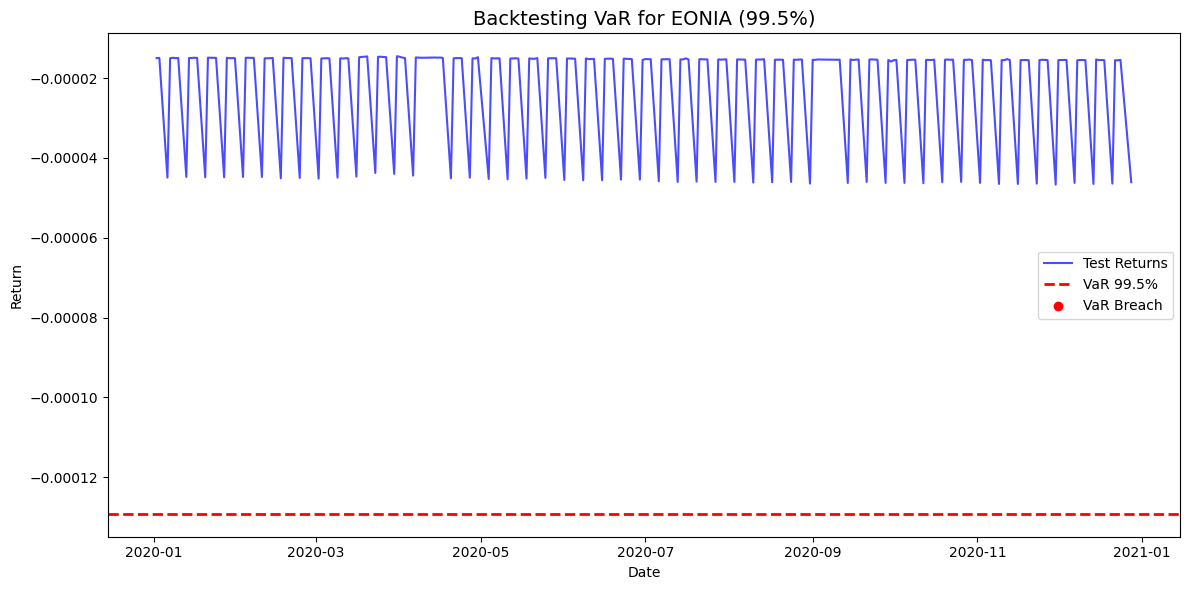


📊 VaR Backtesting Summary for EONIA:
VaR 99.5% threshold: -0.000129
Failures (breaches below VaR): 0 times

📊 VaR Backtesting Results for EONIA

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 2.5263
📊 p-value: 0.111961
🚦 Test Conclusion: ✅ Passed (p > 0.1) - No significant failure pattern detected 🎉

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): -0.0000
📊 p-value: 1.000000
🚦 Test Conclusion: ✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 2.5263
📊 p-value: 0.282759
🚦 Test Conclusion: ✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.000000
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.000000
🚦 A higher value is worse.

Distribution Tests for EONIA
Overall Moments Comparison:
Generated -> Mean: nan, Std: nan, Skewness: nan
Empirical -> Mean: 0.0000, Std: 0.0001, Sk

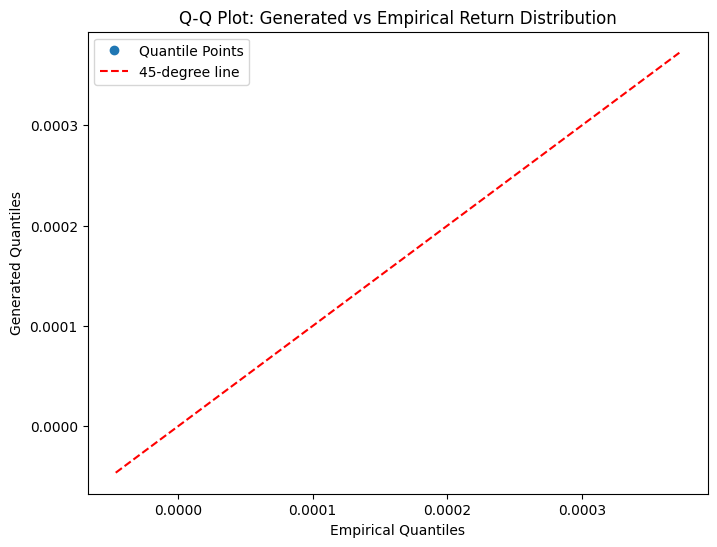


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: nan
Overall Mean Empirical Excess Kurtosis: 8.158122624601413
Difference (Generated - Empirical): nan
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


In [14]:
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


for asset_name in returns_df.columns:
    generated_returns = load_generated_returns(asset_name)
    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)
    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)
    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


## Aggregating the GAN distributions together - Copulas

When aggregated we display the BOF distribtion, as well as the SCR.


In [15]:
from internal_models.multivariate_GAN.students_copula_GAN import StudentsCopulaGAN 
from internal_models.multivariate_GAN.normal_copula_GAN import CopulaGANNormal
from internal_models.multivariate_GAN.clayton_copula_GAN import CopulaGANClayton
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio

## A Little Check on how many of EONIA Returns are NaN

In [16]:
eonia_samples = load_generated_returns('EONIA')
if hasattr(eonia_samples, "cpu"):
    eonia_samples = eonia_samples.cpu().numpy()
else:
    eonia_samples = np.array(eonia_samples)
total_values = eonia_samples.size
nan_count = np.isnan(eonia_samples).sum()
print(f"EONIA NaN count: {nan_count} out of {total_values} ({nan_count/total_values*100:.2f}%)")

EONIA NaN count: 441554 out of 2520000 (17.52%)


In [17]:
from utilities.clean_eonia import clean_eonia

eonia_samples = clean_eonia(eonia_samples)

In [18]:
total_values = eonia_samples.size
nan_count = np.isnan(eonia_samples).sum()
print(f"EONIA NaN count: {nan_count} out of {total_values} ({nan_count/total_values*100:.2f}%)")

EONIA NaN count: 0 out of 2520000 (0.00%)


## Prepering generated GAN returns for Copula

The GANs produce for each scenario (singular input) a 252-day distribution of returns. This is done for each generated scenario.

The GAN returns have shape: Num simulation x 252 days x 7 assets. This leads to a computational problem. Therefore this dimensionality must be reduced somehow. We have decided to reduce this dimensionality by transforming to cumulative returns, giving us a new shape of Num simulation x 7 assets.

In [19]:
gan_samples_list = []
for asset_name in returns_df.columns:

    generated_returns = load_generated_returns(asset_name)

    if hasattr(generated_returns, "cpu"):
        generated_returns = generated_returns.cpu().numpy()
    else:
        generated_returns = np.array(generated_returns)

    if asset_name == 'EONIA':
        generated_returns = eonia_samples
        
    cumulative_returns = np.prod(1 + generated_returns, axis=1) - 1  # shape: (10000,)
    gan_samples_list.append(cumulative_returns)

# Stack these to get an array of shape (10000, n_assets)
gan_samples = np.column_stack(gan_samples_list)


Each Copula implementation gets the cummulative one year ahead distribution for each asset class produced by the GAN. These distributions are visualized below. 

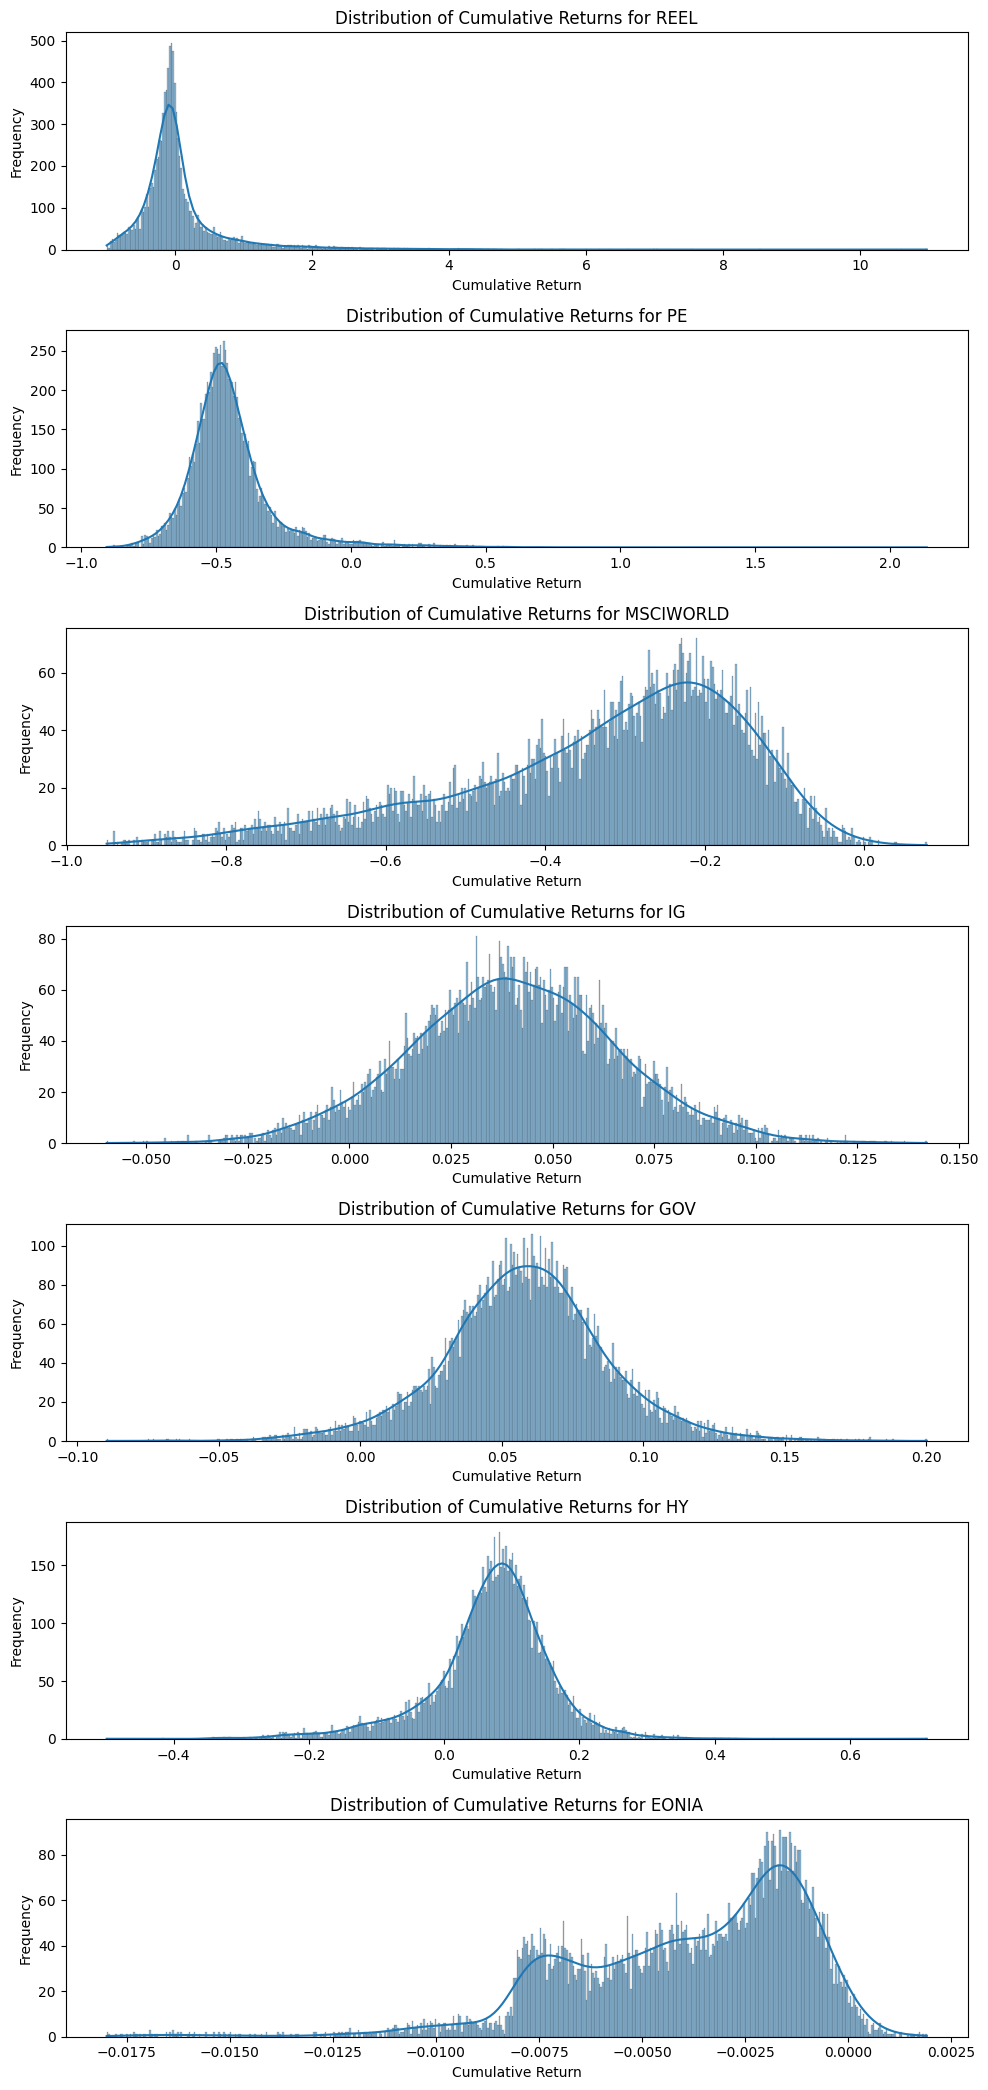

In [20]:
n_assets = gan_samples.shape[1]
fig, axes = plt.subplots(n_assets, 1, figsize=(10, 3 * n_assets), sharex=False)

# If there's only one asset, wrap axes in a list for uniformity.
if n_assets == 1:
    axes = [axes]

for i in range(n_assets):
    ax = axes[i]
    sns.histplot(gan_samples[:, i], bins=500, kde=True, ax=ax)
    ax.set_title(f"Distribution of Cumulative Returns for {returns_df.columns[i]}")
    ax.set_xlabel("Cumulative Return")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Creating the Copulas:

- Student's t
- Gaussian
- Clayton

Also adding a simple weighted portfolio with no fancy math.

In [21]:
if train_gans: 
    student_gan = StudentsCopulaGAN(
    gan_samples=gan_samples,
    weights=weights
    )
    dist_student_gan, scr_student_gan = student_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_student_gan, scr_student_gan, "Student's t Copula GAN", bof_0)

    save_results(model_name="Student's t Copula GAN", distribution=dist_student_gan, scr=scr_student_gan, weights=weights, overwrite=False)

    normal_multi_gan = CopulaGANNormal(
        gan_samples=gan_samples,
        weights=weights
    )
    dist_normal_gan, scr_normal_gan = normal_multi_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_normal_gan, scr_normal_gan, "Normal Copula GAN", bof_0)

    save_results(model_name="Normal Copula GAN", distribution=dist_normal_gan, scr=scr_normal_gan, weights=weights, overwrite=False)
    
    clayton_gan = CopulaGANClayton(
        gan_samples=gan_samples,
        weights=weights
    )
    dist_clayton_gan, scr_clayton_gan = clayton_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_clayton_gan, scr_clayton_gan, 'Clayton Copula GAN', bof_0)

    save_results(model_name='Clayton Copula GAN', distribution=dist_clayton_gan, scr=scr_clayton_gan, weights=weights, overwrite=False)

    simple_gan = SimpleGANPortfolio(
        gan_samples=gan_samples,
        weights=weights
    )

    dist_simple_gan, scr_simple_gan = simple_gan.calculate_distribution_and_scr()
    plot_bof_var(dist_simple_gan, scr_simple_gan, 'Simple GAN', bof_0)

    save_results(model_name='Simple GAN', distribution=dist_simple_gan, scr=scr_simple_gan, weights=weights, overwrite=False)

## Exploring a Conditional GAN
 - By adding marketviews through the condition, we might be able to pass the tests?

## Adding Standard Formula

Potential issues: Is the standard formula time dependent?

In [22]:
from standard_formula.sf import calculate_market_scr
from utilities.map_weights_to_assets import map_weights_to_assets

asset_values = map_weights_to_assets(returns_df, weights)

durations = {
    'gov_bonds': 7.29,
    'IG_corp_bonds': 5.90,
    'HY_corp_bonds': 3.14
}

sf_scr = calculate_market_scr(asset_values, durations)
for key, value in sf_scr.items():
    print(f"{key}: {value:,.3f}")

sf_market_scr = -sf_scr['Total Market SCR'] * assets_0


Market SCR Interest: 0.082
Market SCR Equity: 0.118
Market SCR Real Estate: 0.036
Market SCR Spread: 0.045
Total Market SCR: 0.237


## Performing Backtesting

On 1-year out of sample data, the start of the testing period is defined as START_TEST_DATE inside .env.


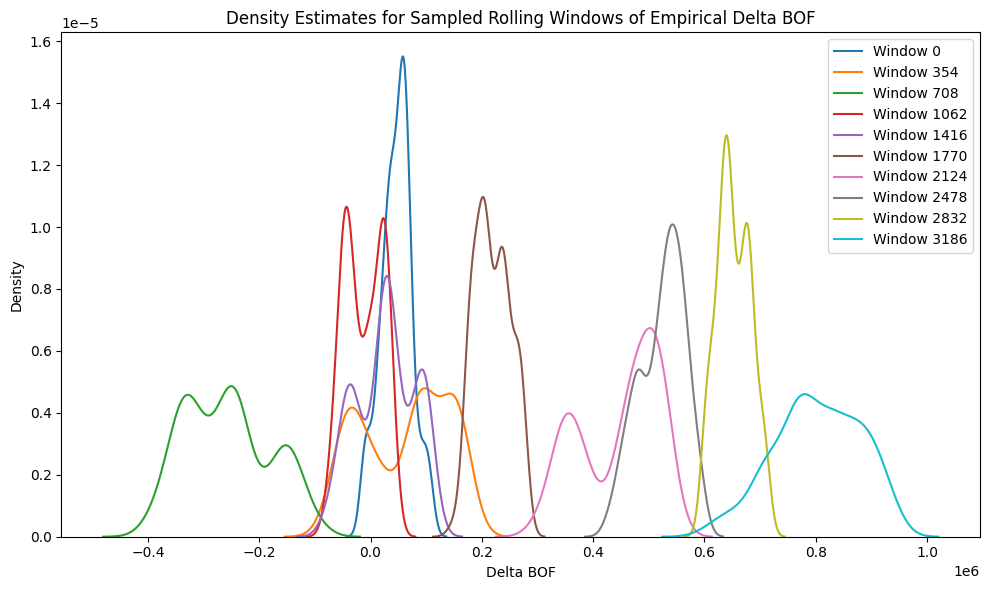

+-----------------------------------------+
|                                         |
|          Historical Simulation          |
|                                         |
+-----------------------------------------+


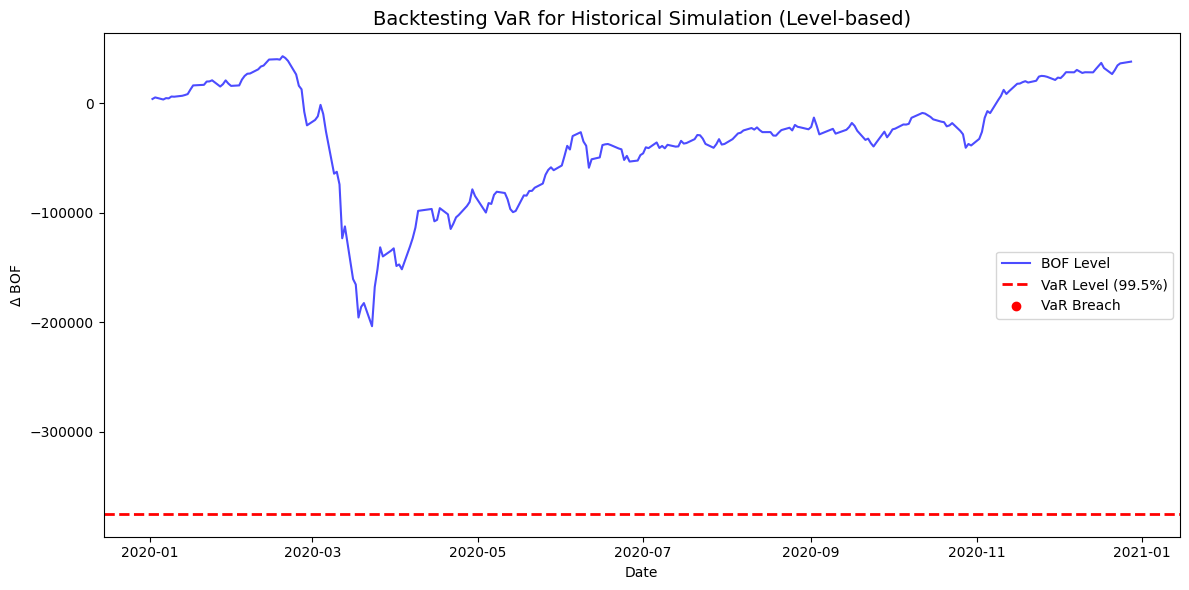


📊 VaR Backtesting Summary for Historical Simulation:
• Confidence Level: 99.5%
• VaR Threshold (Level): -374857.801135
• Failures (BOF below VaR): 0 times


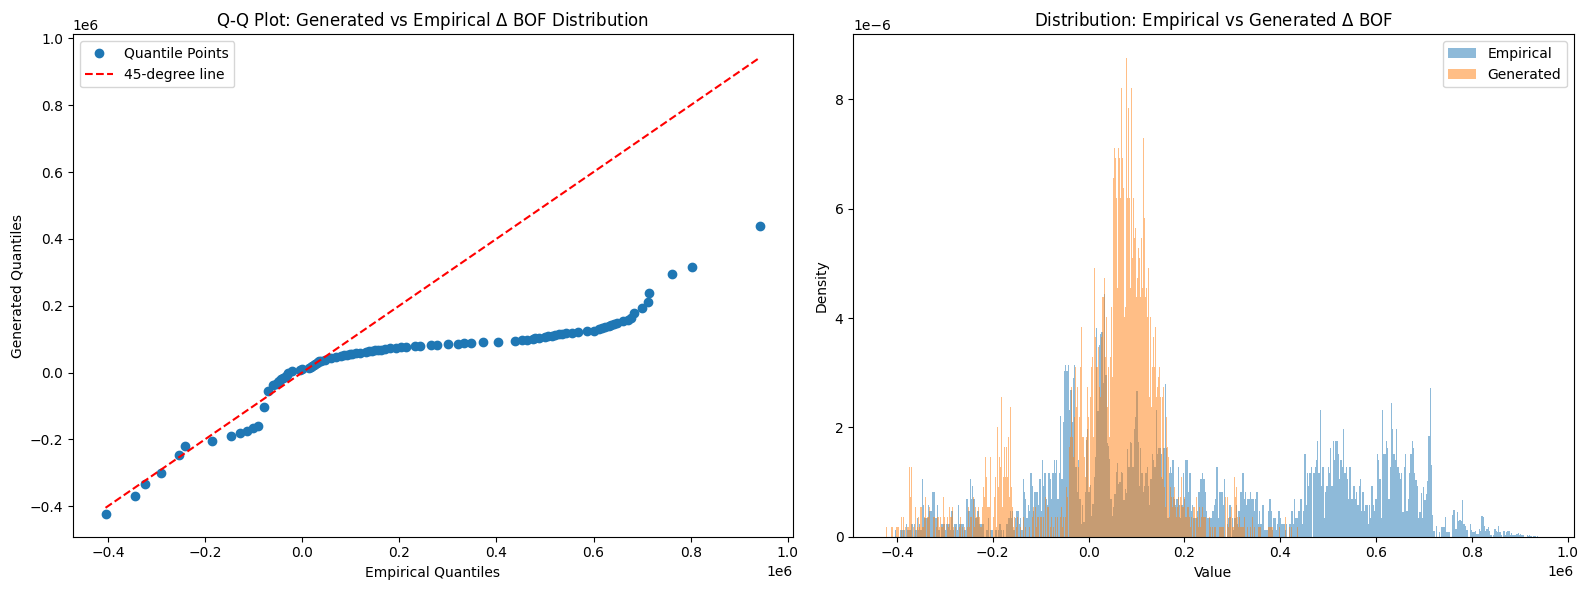

Overall Mean Generated Excess Kurtosis: 2.2517125014448798
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 3.325234233617114
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+-----------------------------+
|                             |
|          MC Copula          |
|                             |
+-----------------------------+


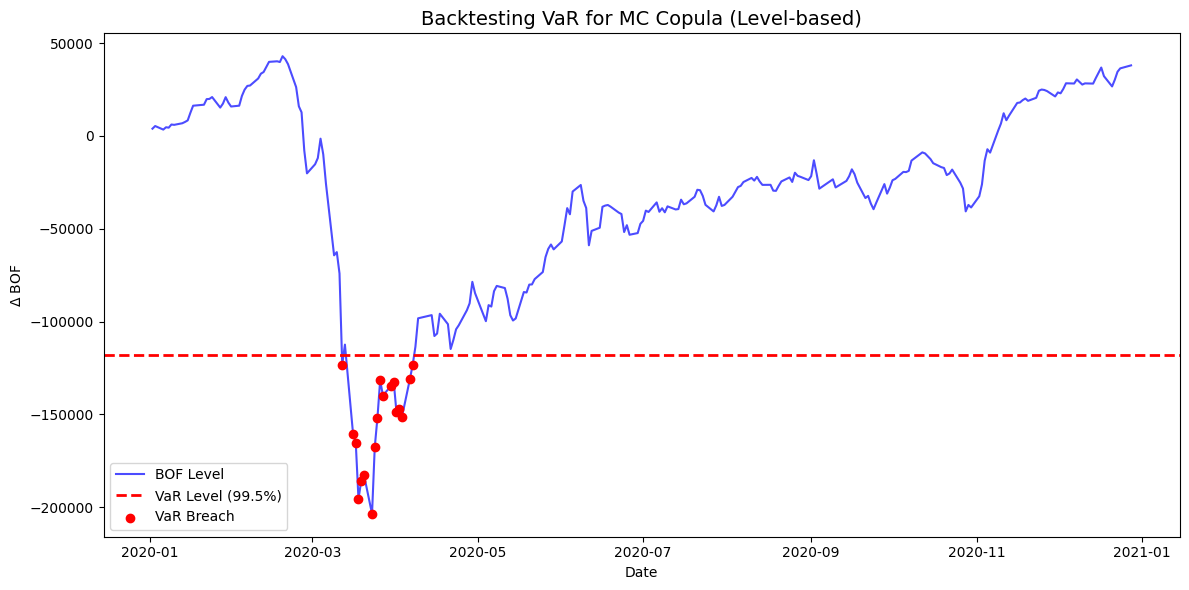


📊 VaR Backtesting Summary for MC Copula:
• Confidence Level: 99.5%
• VaR Threshold (Level): -117841.822873
• Failures (BOF below VaR): 18 times


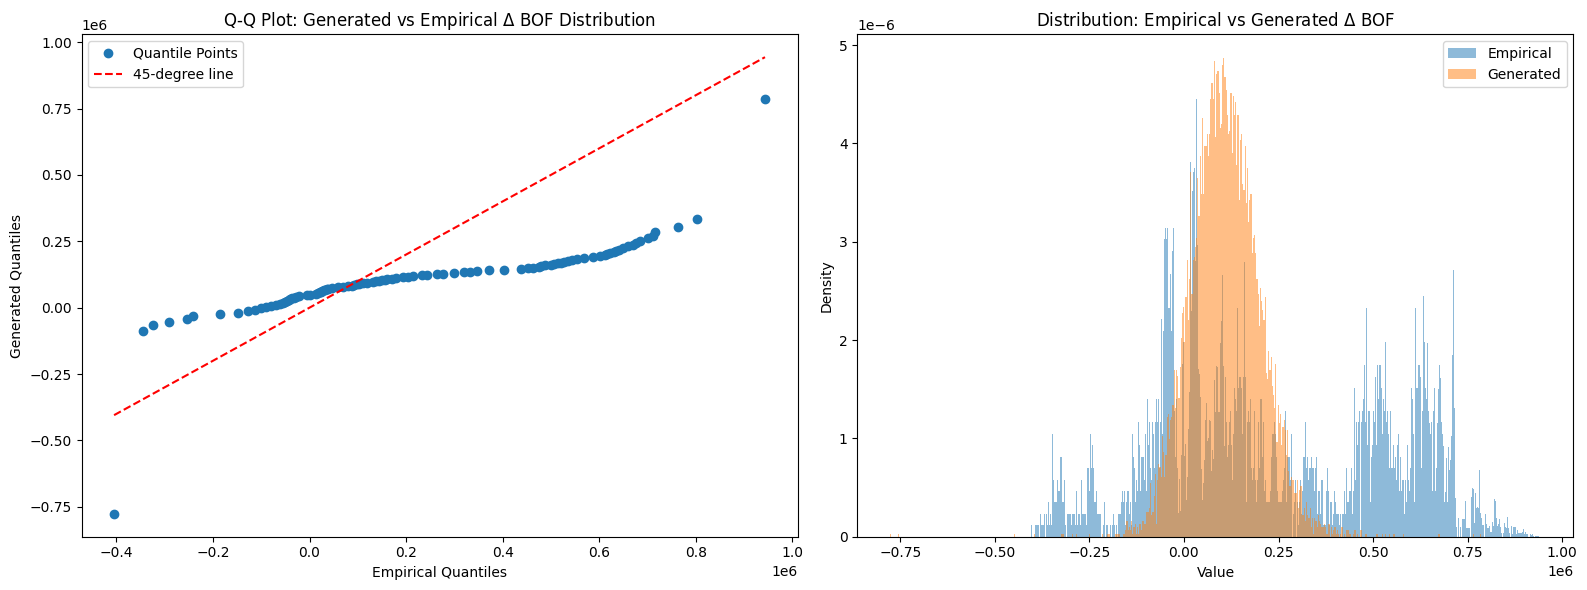

Overall Mean Generated Excess Kurtosis: 2.8740145709235883
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 3.9475363030958226
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+----------------------------------+
|                                  |
|          MC Vanilla GBM          |
|                                  |
+----------------------------------+


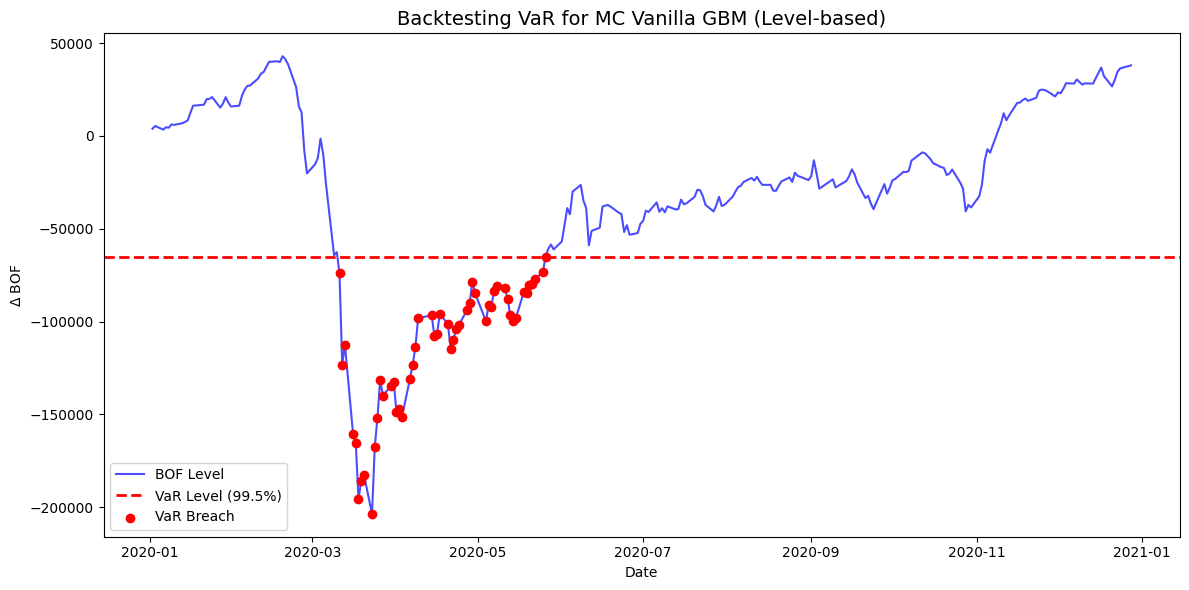


📊 VaR Backtesting Summary for MC Vanilla GBM:
• Confidence Level: 99.5%
• VaR Threshold (Level): -65237.116354
• Failures (BOF below VaR): 52 times


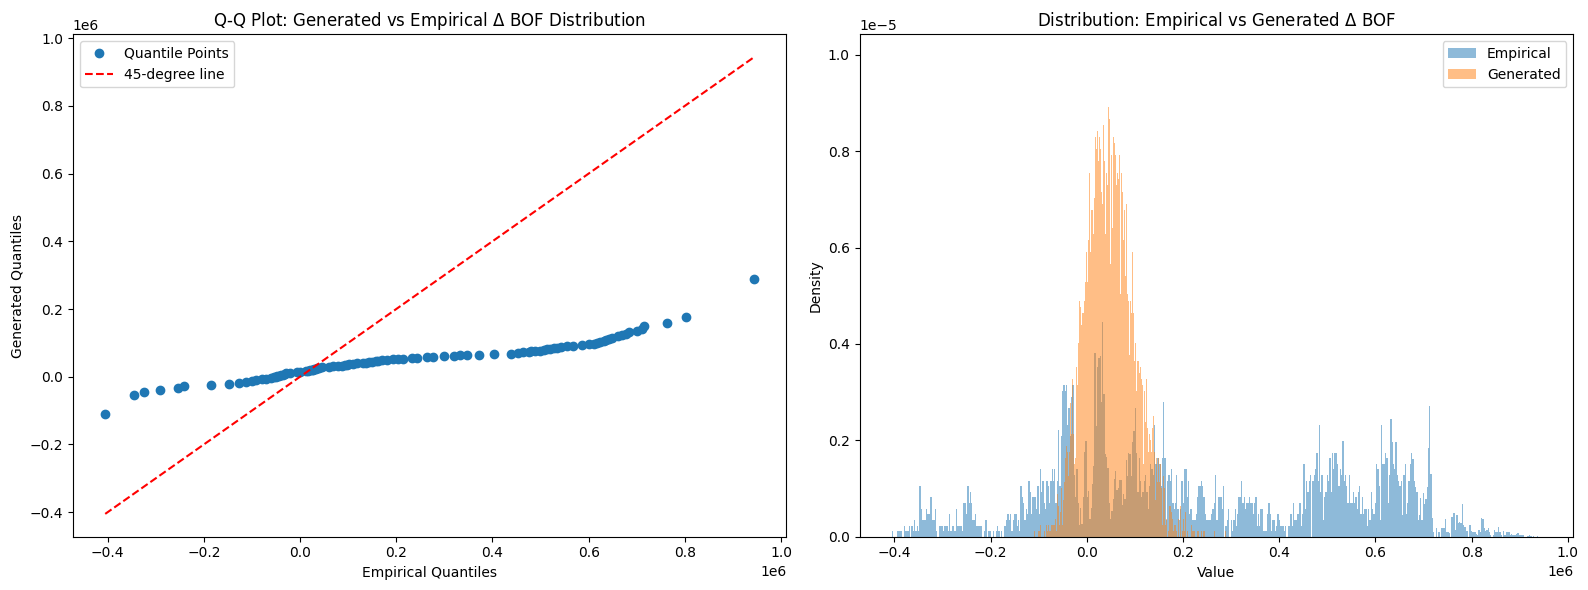

Overall Mean Generated Excess Kurtosis: 0.25111233717093784
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 1.324634069343172
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+-----------------------------------------------------------------------+
|                                                                       |
|          GBM with Poisson Jumps and Intra-Asset Correlations          |
|                                                                       |
+-----------------------------------------------------------------------+


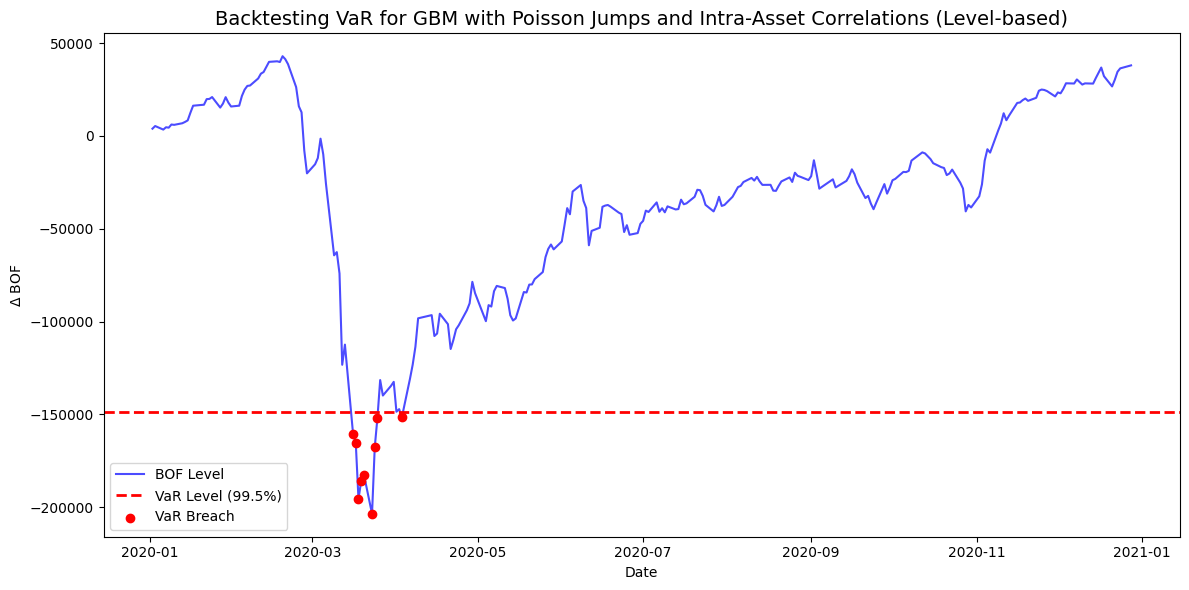


📊 VaR Backtesting Summary for GBM with Poisson Jumps and Intra-Asset Correlations:
• Confidence Level: 99.5%
• VaR Threshold (Level): -148776.926267
• Failures (BOF below VaR): 9 times


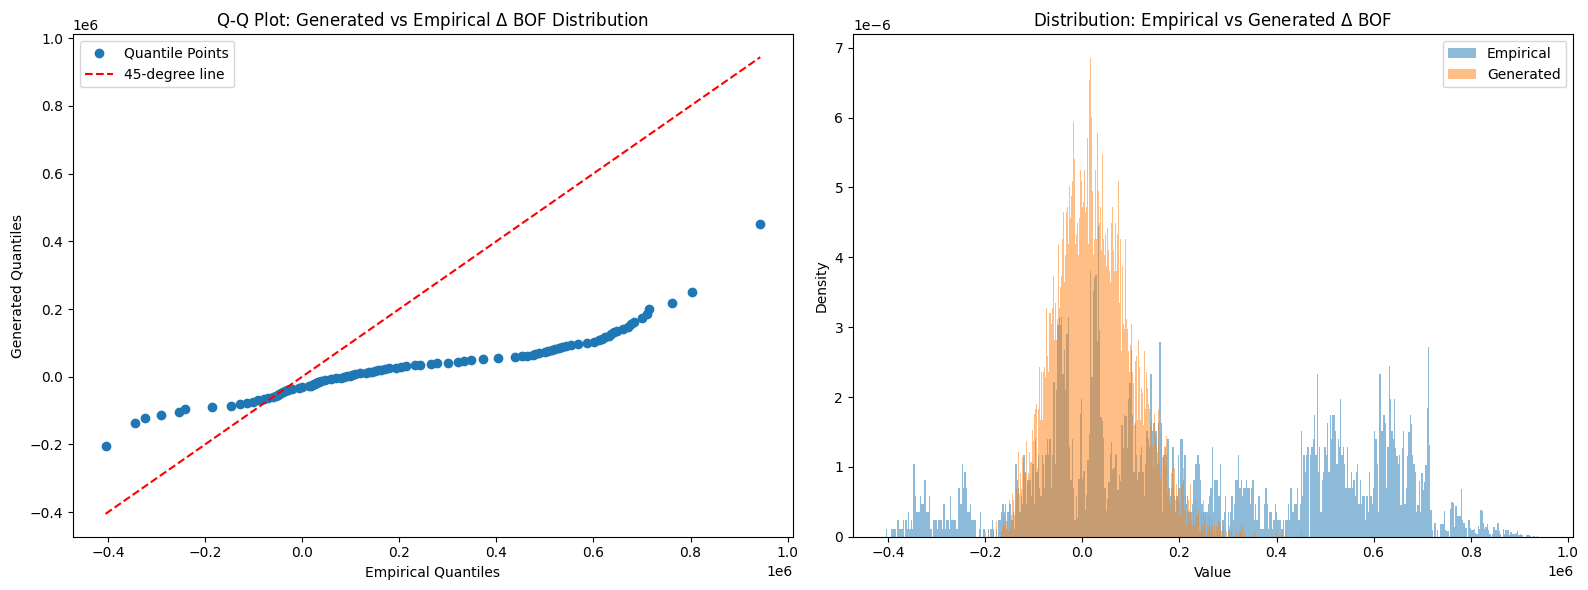

Overall Mean Generated Excess Kurtosis: 0.4257621549564288
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 1.499283887128663
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+--------------------------------------+
|                                      |
|          Clayton Copula GAN          |
|                                      |
+--------------------------------------+


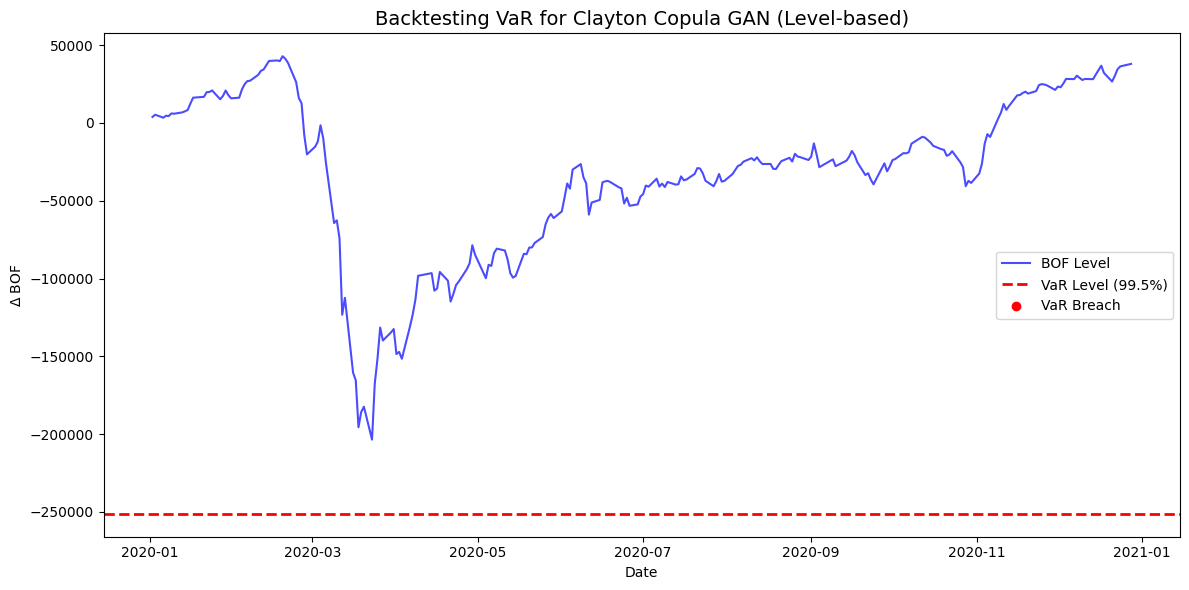


📊 VaR Backtesting Summary for Clayton Copula GAN:
• Confidence Level: 99.5%
• VaR Threshold (Level): -251296.798999
• Failures (BOF below VaR): 0 times


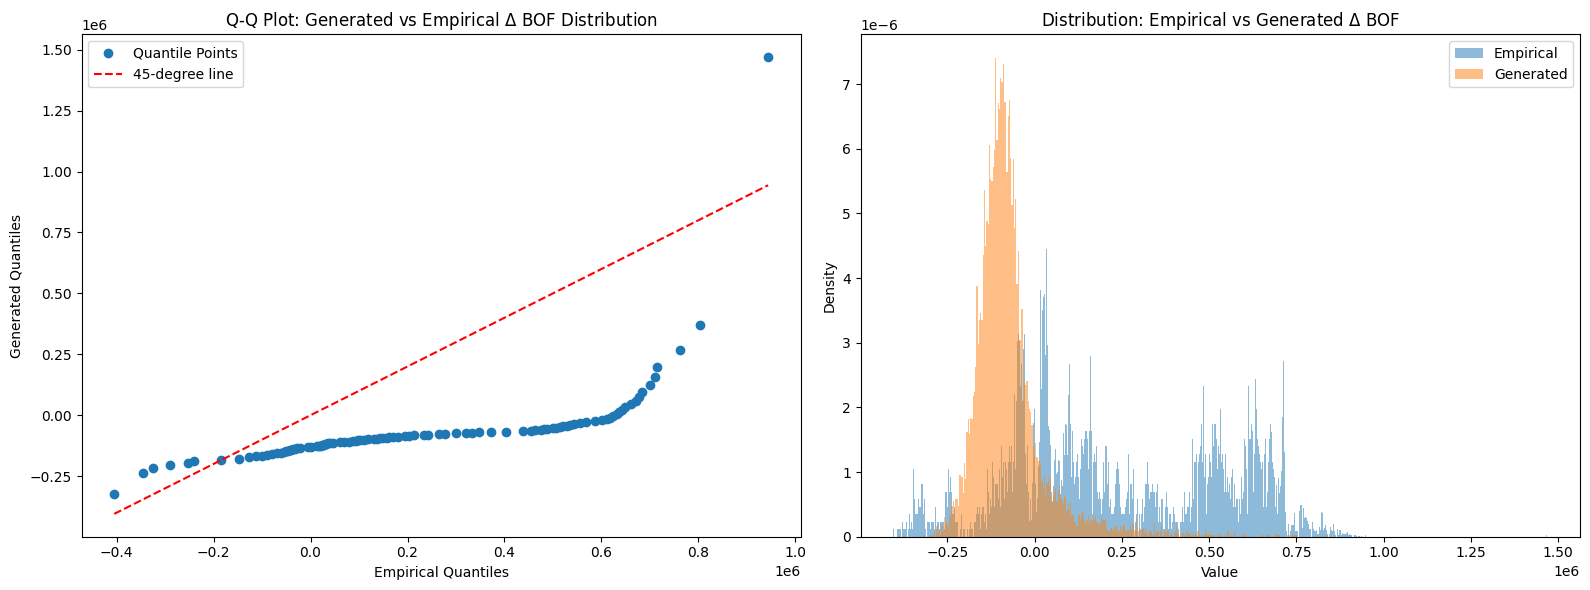

Overall Mean Generated Excess Kurtosis: 15.40068569111871
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 16.474207423290945
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+------------------------------------------+
|                                          |
|          Student's t Copula GAN          |
|                                          |
+------------------------------------------+


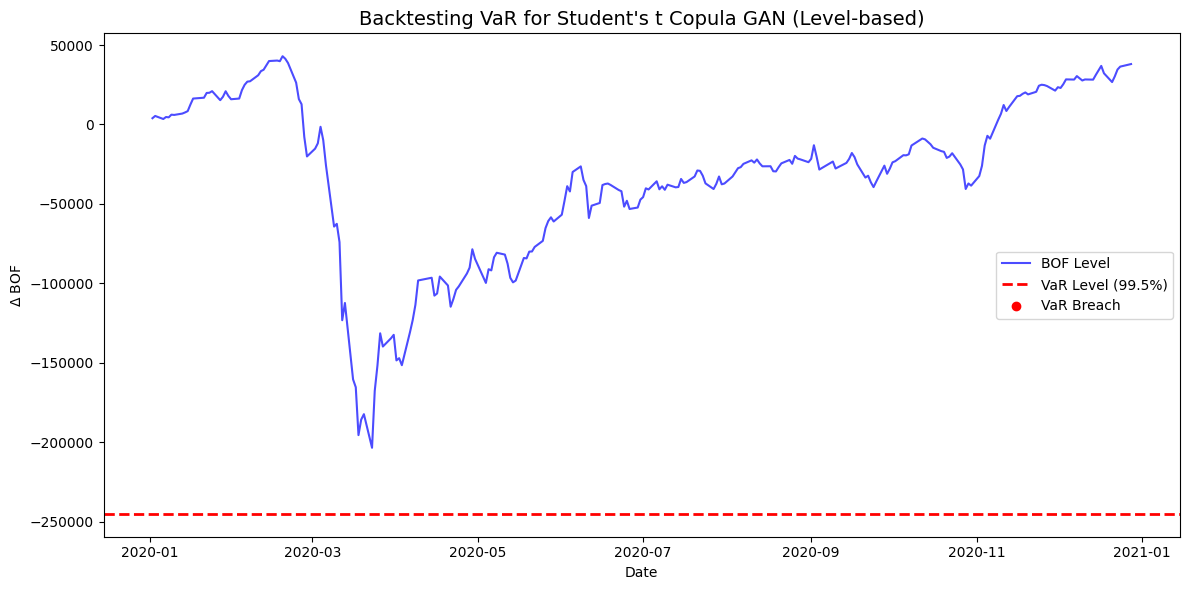


📊 VaR Backtesting Summary for Student's t Copula GAN:
• Confidence Level: 99.5%
• VaR Threshold (Level): -245171.030646
• Failures (BOF below VaR): 0 times


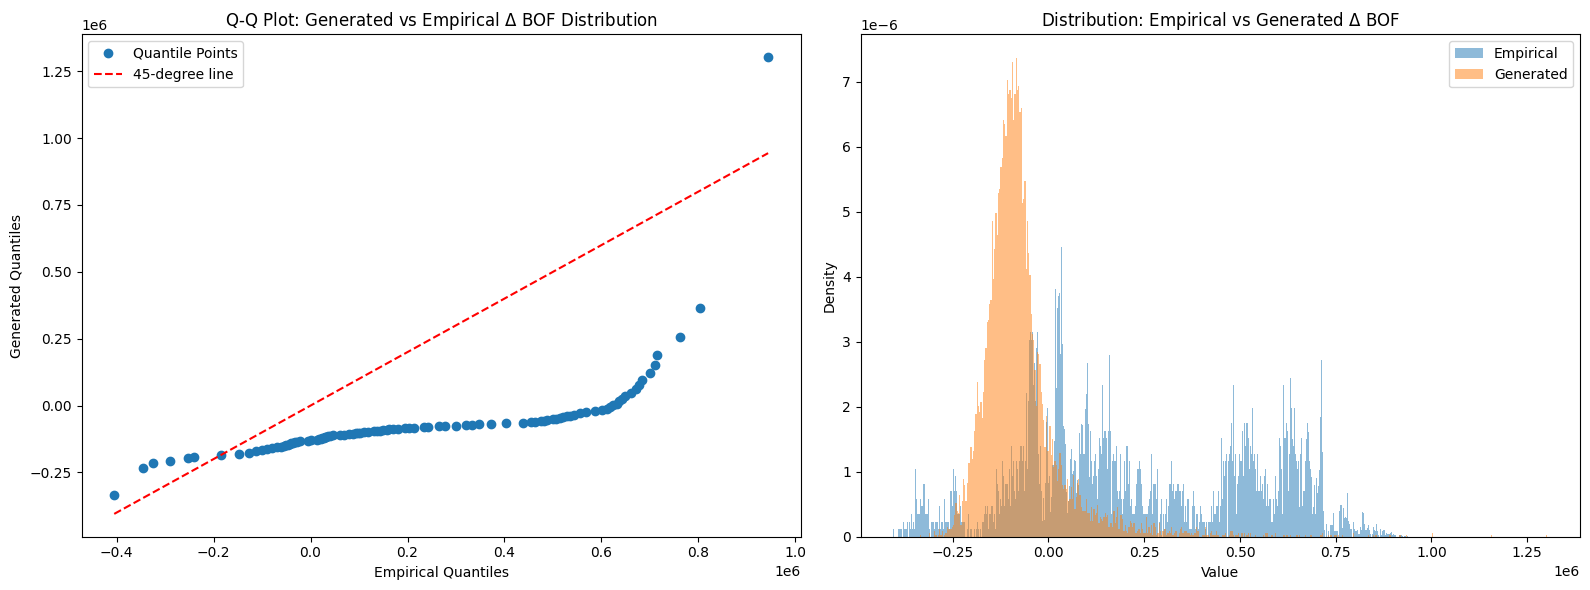

Overall Mean Generated Excess Kurtosis: 17.707775601230107
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 18.781297333402343
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+-------------------------------------+
|                                     |
|          Normal Copula GAN          |
|                                     |
+-------------------------------------+


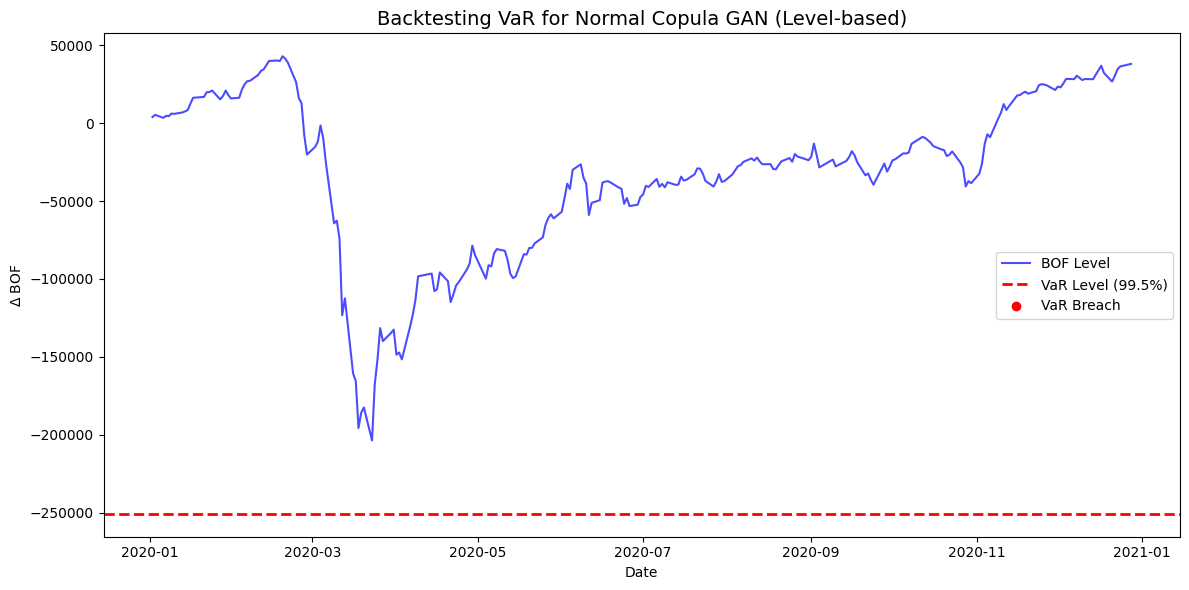


📊 VaR Backtesting Summary for Normal Copula GAN:
• Confidence Level: 99.5%
• VaR Threshold (Level): -250680.356676
• Failures (BOF below VaR): 0 times


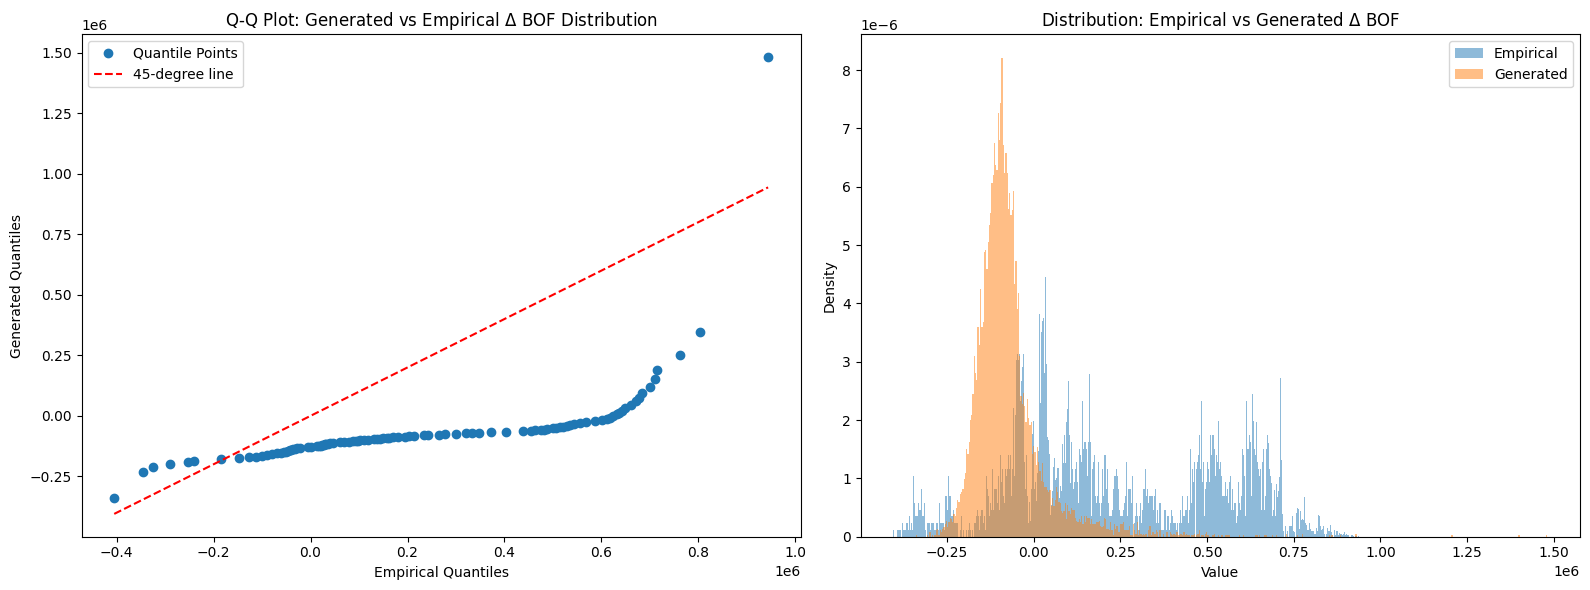

Overall Mean Generated Excess Kurtosis: 20.831891652630905
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 21.90541338480314
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+------------------------------+
|                              |
|          Simple GAN          |
|                              |
+------------------------------+


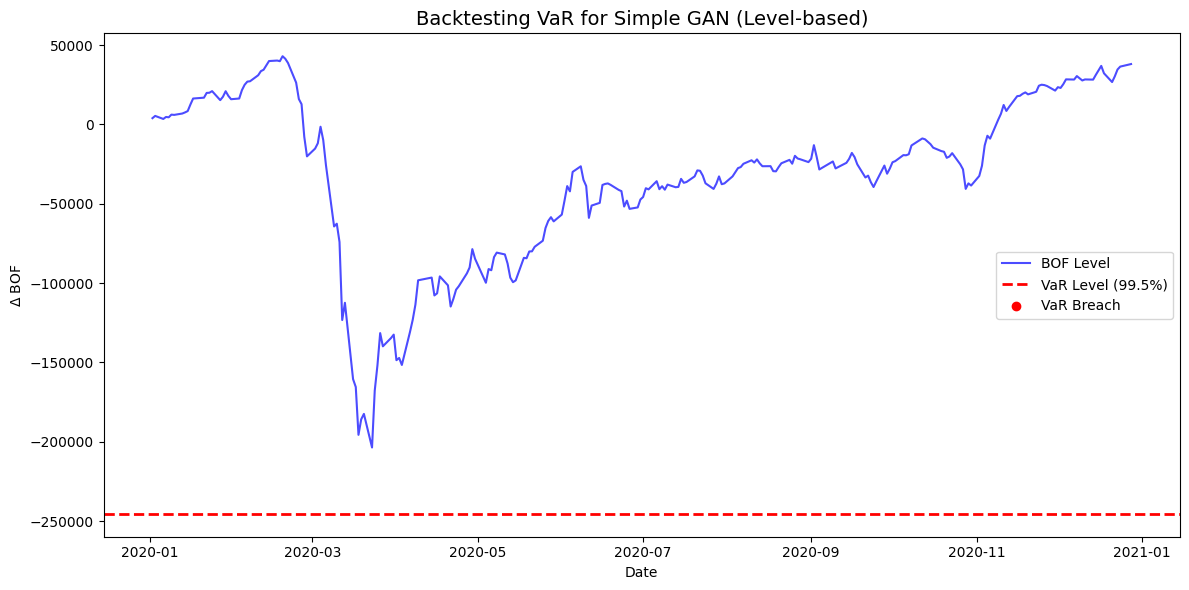


📊 VaR Backtesting Summary for Simple GAN:
• Confidence Level: 99.5%
• VaR Threshold (Level): -245386.327498
• Failures (BOF below VaR): 0 times


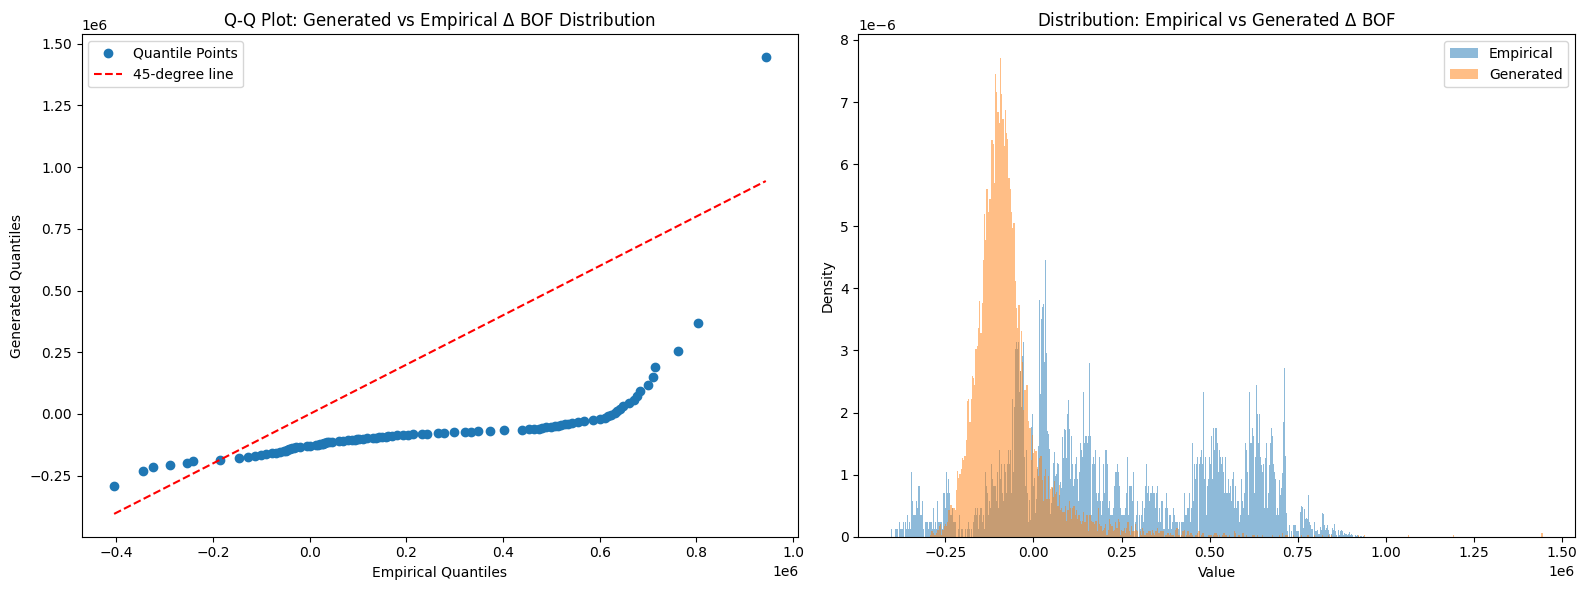

Overall Mean Generated Excess Kurtosis: 21.053258332099865
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): 22.1267800642721
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.
+------------------------------------+
|                                    |
|          Standard Formula          |
|                                    |
+------------------------------------+


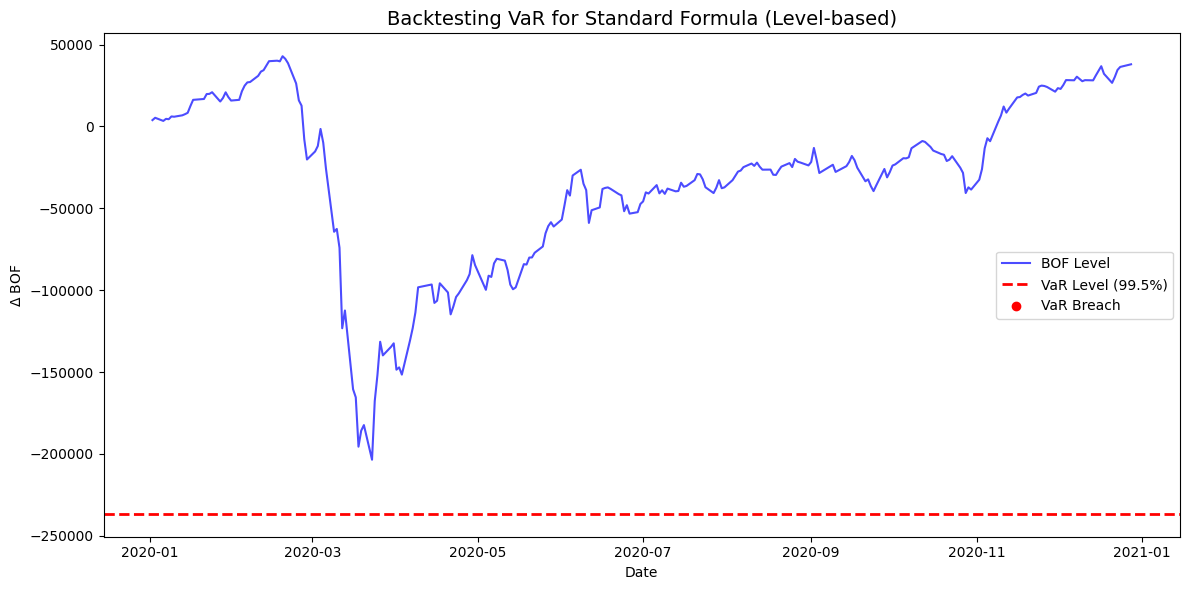


📊 VaR Backtesting Summary for Standard Formula:
• Confidence Level: 99.5%
• VaR Threshold (Level): -236646.023333
• Failures (BOF below VaR): 0 times


c:\Users\nicka\master-thesis\packages\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicka\master-thesis\packages\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\nicka\master-thesis\backtesting\perform_distribution_tests.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  skew_stat, skew_pvalue = skewtest(generated_flat)


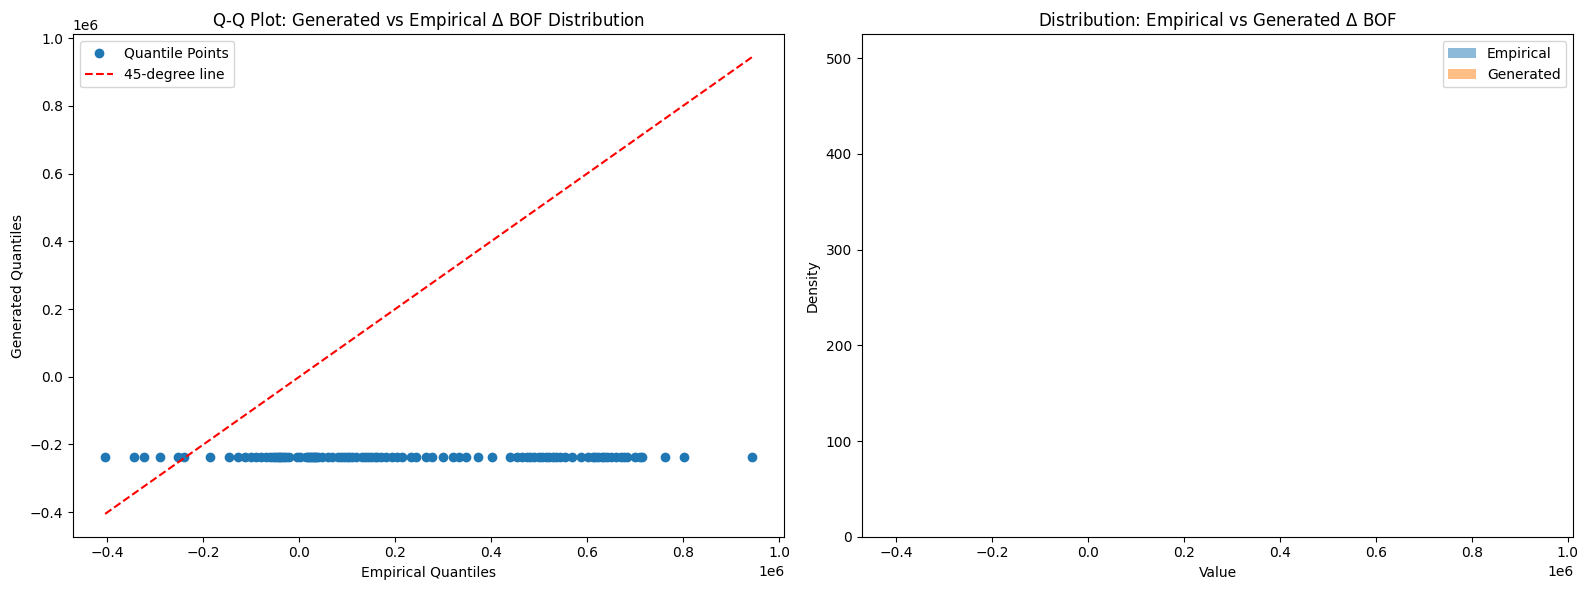

Overall Mean Generated Excess Kurtosis: nan
Overall Mean Empirical Excess Kurtosis: -1.0735217321722341
Difference (Generated - Empirical): nan
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


In [23]:
# Make verbose if you want to visualize more

from backtesting.run_all_tests_on_models import run_all_tests_on_models

benchmark = load_results()
models = {model_name: data["distribution"] for model_name, data in benchmark.items()}

models['Standard Formula'] = sf_market_scr

var_df, dist_df = run_all_tests_on_models(models, returns_df, test_returns_df, weights, assets_0, liabilities_0, verbose=True)

In [24]:
var_df

In [25]:
dist_df